# Small notebook to try investment strategies

In [1]:
import pandas as pd
import bs4 as bs
import requests
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

In [2]:
# get all tickers from wikipedia (S&P100 or S&P500)
resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
# resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [3]:
# clean the tickers and create a list
tickers = []

for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
    
tickers = [s.replace('\n', '') for s in tickers]
#5 years - to remove
tickers.remove('BRK.B')
tickers.remove('DOW')
# need to check
tickers.remove('TXN')
tickers.remove('CVS')
tickers.remove('HD')
tickers.remove('MRK')
tickers.remove('COF')
#ten years - to remove

tickers.remove('KHC')
tickers.remove('ABBV')
tickers.remove('META')
tickers.remove('PYPL')


In [4]:
# download the data for all the tickers
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2022, 12, 31)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  90 of 90 completed


In [5]:
# create a nice dataset, but keep only Adj Close (most relevant for backtesting)
df = data.stack().reset_index().rename(index=str, columns={"level_1": "Symbol"}).sort_values(['Symbol','Date'])
df.set_index('Date', inplace=True)
df = df[['Symbol', 'Adj Close']]

In [6]:
# let's get one stock, just to have unique dates column
df_temp = df[df['Symbol']=='AAPL']
df_temp = df_temp.drop('Symbol', axis=1)

In [30]:
# # let's plot it, just for fun
# '''
# # also this way is fine, 
# days = df_temp.index.values
# unemployment_rate = df_temp['Adj Close'].tolist()
  
# plt.plot(days, unemployment_rate, color='red', marker='o')
# plt.title('unemployment rate vs year', fontsize=14)
# plt.xlabel('year', fontsize=14)
# plt.ylabel('unemployment rate', fontsize=14)
# plt.grid(True)
# plt.show()
# '''

# plt.xticks(df_temp['Adj Close'], df_temp.index.values)
# plt.plot(df_temp['Adj Close'], color='black')
# plt.title('Stock evolution', fontsize=14)
# #plt.xlabel('days', fontsize=14)
# plt.ylabel('US Dollars', fontsize=14)
# plt.grid(True)
# plt.show()


In [21]:
#this are params to optimize - they can even change based on certain conditions
interval_back_window_days = 30
percentage_down = 0.1
percentage_up = 0.05
# this number could be dynamic, could depend on many factors - for the moment I will keep it easy and keep it constant
number_of_positions = 10
investment = 1
description = ""

# initialize variables
invest_status = [0] * len(tickers)
current_status = [0] * len(tickers)
invest_flag = [0] * len(tickers)
saved_max = [0] * len(tickers)
saved_current = [0] * len(tickers)
portfolio_value = []
new_buy = []
new_sell = []
portfolio_composition_history = []
year_0 = 0
new_start = False


# for date_0 in list(set(df.index.values)):
for date_0 in df_temp.index.values:
    portfolio_composition = {}
    buy = 0
    sell = 0
    start_date = str(date_0)[0:10]
    
#     # in case we want to re-start from zero every year
#     if year_0 != 0 and year_0 != start_date[0:4] and (start_date[0:4]=='2022' or start_date[0:4]=='2020') :
#         new_start = True
#         sell = sum(invest_flag)
#         investment = investment + sum(current_status)
#         current_status = [0] * len(tickers)
#         invest_status = [0] * len(tickers)
#         current_status = [0] * len(tickers)
#         invest_flag = [0] * len(tickers)
#         saved_max = [0] * len(tickers)
#         saved_current = [0] * len(tickers)
#     year_0 = start_date[0:4]
    
    for index, t in enumerate(tickers):
        df_temp_2 = df[df['Symbol']==t]

        # define start_date and end_date for the window
        date_1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")
        end_date = date_1 + datetime.timedelta(days=interval_back_window_days)
        df_temp_2 = df_temp_2.loc[date_1:end_date]
        
        # pick current price and max price of last interval
        stock_0 = df_temp_2.iloc[-1]['Adj Close']
        stock_max = df_temp_2['Adj Close'].max()
        
        # check if you are already invested
        if invest_flag[index]>0:
            current_status[index] = invest_status[index]*(stock_0/saved_current[index])
            if stock_0 >= saved_max[index]*(1-percentage_up):
                investment = investment + invest_status[index]*(stock_0/saved_current[index])
                invest_status[index]=0
                invest_flag[index] = 0
                current_status[index] = 0
                sell = sell + 1
            else:
                portfolio_composition[t] = invest_status[index]*(stock_0/saved_current[index])
                
                
        # check if you should invest
        elif stock_0 <= (1-percentage_down)*stock_max and investment>0:
            invest_status[index]=investment/(number_of_positions-sum(invest_flag))
            investment = investment - invest_status[index]
            invest_flag[index] = 1
            saved_max[index]= stock_max
            saved_current[index] = stock_0
            current_status[index] = invest_status[index]
            buy = buy + 1
            portfolio_composition[t] = invest_status[index]
            
    print('portfolio value at date ' + str(start_date) + ': ' + str(investment + sum(current_status)))
    portfolio_value.append(investment + sum(current_status))
    new_buy.append(buy)
    new_sell.append(sell)
    if investment > 0:
        # add cash to the portfolio composition
        portfolio_composition['CASH'] = investment
    portfolio_composition_history.append(portfolio_composition)
    print(portfolio_composition)

# generate DF with portoflio evolution
df_results = pd.DataFrame({'dates': df_temp.index.values, 'portfolio':portfolio_value, 'buys': new_buy,
                          'sells': new_sell, 'portfolio composition': portfolio_composition_history})

df_results.to_excel('investment_output_10y_pd'+ str(percentage_down) + '_pu' + 
                    str(percentage_up) + description + '.xlsx', index=False)
              
# calculate final return
total_return = investment + sum(current_status)
print('Total return:')
print(total_return)

portfolio value at date 2013-01-02: 1.0
{'AAPL': 0.1, 'CASH': 0.9}
portfolio value at date 2013-01-03: 1.0
{'AAPL': 0.1, 'CASH': 0.9}
portfolio value at date 2013-01-04: 1.0
{'AAPL': 0.1, 'CASH': 0.9}
portfolio value at date 2013-01-07: 1.0008222765989312
{'AAPL': 0.10082227659893124, 'CASH': 0.9}
portfolio value at date 2013-01-08: 1.0038201007091698
{'AAPL': 0.10382010070916976, 'CASH': 0.9}
portfolio value at date 2013-01-09: 1.005319012764289
{'AAPL': 0.10531901276428901, 'CASH': 0.9}
portfolio value at date 2013-01-10: 1.005319012764289
{'AAPL': 0.10531901276428901, 'CASH': 0.9}
portfolio value at date 2013-01-11: 1.005319012764289
{'AAPL': 0.10531901276428901, 'CASH': 0.9}
portfolio value at date 2013-01-14: 1.0035518313259675
{'AAPL': 0.10355183132596757, 'CASH': 0.9}
portfolio value at date 2013-01-15: 1.0034587118962603
{'AAPL': 0.10345871189626042, 'CASH': 0.9}
portfolio value at date 2013-01-16: 1.0020329660851974
{'AAPL': 0.1020329660851973, 'CASH': 0.9}
portfolio value at 

portfolio value at date 2013-03-13: 1.033493745178697
{'AAPL': 0.09530111718673635, 'AMD': 0.09802371727740304, 'C': 0.10884158526912965, 'CRM': 0.10523040657036138, 'FDX': 0.10173886914347438, 'MS': 0.10677413808613868, 'NFLX': 0.10540553366420147, 'ORCL': 0.1055786622970319, 'CASH': 0.20659971568422003}
portfolio value at date 2013-03-14: 1.033493745178697
{'AAPL': 0.09530111718673635, 'AMD': 0.09802371727740304, 'C': 0.10884158526912965, 'CRM': 0.10523040657036138, 'FDX': 0.10173886914347438, 'MS': 0.10677413808613868, 'NFLX': 0.10540553366420147, 'ORCL': 0.1055786622970319, 'CASH': 0.20659971568422003}
portfolio value at date 2013-03-15: 1.033493745178697
{'AAPL': 0.09530111718673635, 'AMD': 0.09802371727740304, 'C': 0.10884158526912965, 'CRM': 0.10523040657036138, 'FDX': 0.10173886914347438, 'MS': 0.10677413808613868, 'NFLX': 0.10540553366420147, 'ORCL': 0.1055786622970319, 'CASH': 0.20659971568422003}
portfolio value at date 2013-03-18: 1.015886789724915
{'AAPL': 0.08931433324599

portfolio value at date 2013-04-30: 1.1489626064868381
{'AAPL': 0.10079326062844252, 'AMD': 0.12409719241523597, 'CRM': 0.11893898204492401, 'EXC': 0.11607753615376064, 'FDX': 0.10193953898982529, 'NFLX': 0.12059488491685241, 'CASH': 0.4665212113377971}
portfolio value at date 2013-05-01: 1.147289633584696
{'AAPL': 0.10038034262802689, 'AMD': 0.12286850850198158, 'CRM': 0.11774292622481307, 'EXC': 0.1154879399996941, 'FDX': 0.1017494316565752, 'NFLX': 0.12253927323580811, 'TSLA': 0.11663030283444928, 'CASH': 0.3498909085033478}
portfolio value at date 2013-05-02: 1.147289633584696
{'AAPL': 0.10038034262802689, 'AMD': 0.12286850850198158, 'CRM': 0.11774292622481307, 'EXC': 0.1154879399996941, 'FDX': 0.1017494316565752, 'NFLX': 0.12253927323580811, 'TSLA': 0.11663030283444928, 'CASH': 0.3498909085033478}
portfolio value at date 2013-05-03: 1.147289633584696
{'AAPL': 0.10038034262802689, 'AMD': 0.12286850850198158, 'CRM': 0.11774292622481307, 'EXC': 0.1154879399996941, 'FDX': 0.1017494316

portfolio value at date 2013-06-05: 1.1526934396741764
{'AAPL': 0.09316867266343748, 'AMD': 0.1250187126737106, 'AMGN': 0.12037823130003074, 'AMT': 0.11057408492089335, 'BLK': 0.1284426016551659, 'CRM': 0.10831347004892584, 'EXC': 0.10959193702328147, 'FDX': 0.10467759302146047, 'GILD': 0.12407679961559719, 'WBA': 0.12845133675167317}
portfolio value at date 2013-06-06: 1.1526934396741764
{'AAPL': 0.09316867266343748, 'AMD': 0.1250187126737106, 'AMGN': 0.12037823130003074, 'AMT': 0.11057408492089335, 'BLK': 0.1284426016551659, 'CRM': 0.10831347004892584, 'EXC': 0.10959193702328147, 'FDX': 0.10467759302146047, 'GILD': 0.12407679961559719, 'WBA': 0.12845133675167317}
portfolio value at date 2013-06-07: 1.1526934396741764
{'AAPL': 0.09316867266343748, 'AMD': 0.1250187126737106, 'AMGN': 0.12037823130003074, 'AMT': 0.11057408492089335, 'BLK': 0.1284426016551659, 'CRM': 0.10831347004892584, 'EXC': 0.10959193702328147, 'FDX': 0.10467759302146047, 'GILD': 0.12407679961559719, 'WBA': 0.12845133

portfolio value at date 2013-07-23: 1.2372538164534217
{'AAPL': 0.11300255674576479, 'AMD': 0.11766800910346649, 'AMT': 0.10626962580125215, 'EXC': 0.11434445839976225, 'MSFT': 0.13570241390722346, 'SPG': 0.13056476734102535, 'TGT': 0.1271257263398734, 'V': 0.1333379375000986, 'CASH': 0.2592383213149553}
portfolio value at date 2013-07-24: 1.2514364231784838
{'AAPL': 0.11256669429310143, 'AMD': 0.11831631705485414, 'AMT': 0.10809011633852297, 'EXC': 0.11523778548738076, 'SPG': 0.13158172687574238, 'TGT': 0.12734340354309492, 'V': 0.1334721022352041, 'CASH': 0.40482827735058324}
portfolio value at date 2013-07-25: 1.2514364231784838
{'AAPL': 0.11256669429310143, 'AMD': 0.11831631705485414, 'AMT': 0.10809011633852297, 'EXC': 0.11523778548738076, 'SPG': 0.13158172687574238, 'TGT': 0.12734340354309492, 'V': 0.1334721022352041, 'CASH': 0.40482827735058324}
portfolio value at date 2013-07-26: 1.2514364231784838
{'AAPL': 0.11256669429310143, 'AMD': 0.11831631705485414, 'AMT': 0.10809011633852

portfolio value at date 2013-08-28: 1.277769213219927
{'AAPL': 0.10846187565694923, 'AMD': 0.1251235505444246, 'AMT': 0.115397698090141, 'CSCO': 0.13425225651955774, 'EXC': 0.1106967452590813, 'JPM': 0.13937145599106962, 'SPG': 0.13390117828688977, 'TGT': 0.12653205057090403, 'CASH': 0.28403240230090987}
portfolio value at date 2013-08-29: 1.277769213219927
{'AAPL': 0.10846187565694923, 'AMD': 0.1251235505444246, 'AMT': 0.115397698090141, 'CSCO': 0.13425225651955774, 'EXC': 0.1106967452590813, 'JPM': 0.13937145599106962, 'SPG': 0.13390117828688977, 'TGT': 0.12653205057090403, 'CASH': 0.28403240230090987}
portfolio value at date 2013-08-30: 1.277769213219927
{'AAPL': 0.10846187565694923, 'AMD': 0.1251235505444246, 'AMT': 0.115397698090141, 'CSCO': 0.13425225651955774, 'EXC': 0.1106967452590813, 'JPM': 0.13937145599106962, 'SPG': 0.13390117828688977, 'TGT': 0.12653205057090403, 'CASH': 0.28403240230090987}
portfolio value at date 2013-09-03: 1.2726041635026117
{'AAPL': 0.1086101863511174

portfolio value at date 2013-10-04: 1.2912705066150418
{'AMD': 0.1072950664243831, 'CSCO': 0.13082803861388756, 'EXC': 0.1067140517254381, 'IBM': 0.14626339478014452, 'LLY': 0.14788702605350187, 'NFLX': 0.13285415931023356, 'TGT': 0.12787773325153737, 'TSLA': 0.13288769369761402, 'UNH': 0.13029992650766176, 'CASH': 0.1283634162506399}
portfolio value at date 2013-10-07: 1.29688439775291
{'AMD': 0.10761922040007693, 'CSCO': 0.13494362409601654, 'EXC': 0.10797959613091171, 'IBM': 0.14701602258902718, 'LLY': 0.14820993199201155, 'NFLX': 0.1354203028189026, 'TGT': 0.1300149445034572, 'TSLA': 0.1238657284599055, 'UNH': 0.13345161051196097, 'CASH': 0.1283634162506399}
portfolio value at date 2013-10-08: 1.2765633247353414
{'AMD': 0.1063226044973016, 'CSCO': 0.1339581929280439, 'EXC': 0.10630464582439535, 'IBM': 0.1476805738008981, 'LLY': 0.14680093846531905, 'NFLX': 0.131881774974448, 'TGT': 0.12827347797684424, 'TSLA': 0.11453236549472501, 'UNH': 0.13244533452272614, 'CASH': 0.1283634162506

portfolio value at date 2013-11-14: 1.304194467174044
{'AMD': 0.11961293295762947, 'CRM': 0.14071110948346505, 'CSCO': 0.11732208548360334, 'EXC': 0.10425083466854264, 'LOW': 0.14305508248790044, 'TGT': 0.12420377395338525, 'TSLA': 0.12098951064712103, 'CASH': 0.43404913749239665}
portfolio value at date 2013-11-15: 1.304194467174044
{'AMD': 0.11961293295762947, 'CRM': 0.14071110948346505, 'CSCO': 0.11732208548360334, 'EXC': 0.10425083466854264, 'LOW': 0.14305508248790044, 'TGT': 0.12420377395338525, 'TSLA': 0.12098951064712103, 'CASH': 0.43404913749239665}
portfolio value at date 2013-11-18: 1.320620710057093
{'AMD': 0.11831631705485414, 'CRM': 0.14684812695228278, 'CSCO': 0.1217274756344555, 'EXC': 0.10511641361739642, 'LOW': 0.14672936454180902, 'TGT': 0.12657395859156287, 'TSLA': 0.12125991617233554, 'CASH': 0.43404913749239665}
portfolio value at date 2013-11-19: 1.3090313068388602
{'AMD': 0.11831631705485414, 'CRM': 0.14605003679537645, 'CSCO': 0.1221332608133226, 'EXC': 0.102444

portfolio value at date 2013-12-31: 1.4027134141877202
{'AAPL': 0.15269748043566256, 'AMD': 0.1414378494680574, 'BA': 0.1491625333280631, 'C': 0.1498305160151184, 'CSCO': 0.12838110054719998, 'EXC': 0.10910581974209965, 'GE': 0.15636647926076452, 'GM': 0.15303535914510258, 'TGT': 0.11287086715041245, 'TSLA': 0.14982540909523948}
portfolio value at date 2014-01-02: 1.3897072462957332
{'AAPL': 0.15294794804050504, 'AMD': 0.139405698407609, 'BA': 0.14766536562242338, 'C': 0.1471317641092232, 'CSCO': 0.1279722732806253, 'EXC': 0.1091434848363811, 'GE': 0.15409764370099804, 'GM': 0.14987828851394303, 'TGT': 0.11281115922366279, 'TSLA': 0.14865362056036238}
portfolio value at date 2014-01-03: 1.3897072462957332
{'AAPL': 0.15294794804050504, 'AMD': 0.139405698407609, 'BA': 0.14766536562242338, 'C': 0.1471317641092232, 'CSCO': 0.1279722732806253, 'EXC': 0.1091434848363811, 'GE': 0.15409764370099804, 'GM': 0.14987828851394303, 'TGT': 0.11281115922366279, 'TSLA': 0.14865362056036238}
portfolio v

portfolio value at date 2014-02-06: 1.4808719205905514
{'AMD': 0.16054008881639362, 'AMZN': 0.15749707861493098, 'BA': 0.15238670034608448, 'C': 0.1539252645241174, 'CSCO': 0.12692091310821366, 'EXC': 0.1134226994835488, 'GE': 0.1616295586111989, 'GM': 0.15656630614018924, 'TGT': 0.12191913644629351, 'CASH': 0.17606417449958095}
portfolio value at date 2014-02-07: 1.4808719205905514
{'AMD': 0.16054008881639362, 'AMZN': 0.15749707861493098, 'BA': 0.15238670034608448, 'C': 0.1539252645241174, 'CSCO': 0.12692091310821366, 'EXC': 0.1134226994835488, 'GE': 0.1616295586111989, 'GM': 0.15656630614018924, 'TGT': 0.12191913644629351, 'CASH': 0.17606417449958095}
portfolio value at date 2014-02-10: 1.4572379978554464
{'AMD': 0.15891436796803488, 'AMZN': 0.15689596814789655, 'BA': 0.14751424923630552, 'C': 0.14883790456967283, 'CSCO': 0.127446571203424, 'EXC': 0.11479196447043295, 'GE': 0.15934090275768206, 'GM': 0.14481034687730865, 'TGT': 0.12262154812510777, 'CASH': 0.17606417449958095}
portfo

portfolio value at date 2014-03-14: 1.3914157286427735
{'AMD': 0.1483471727636426, 'AMZN': 0.13195872481313276, 'BA': 0.14471639669725492, 'C': 0.14170308483132932, 'CRM': 0.15761111583626972, 'CSCO': 0.13230596545589174, 'GE': 0.15729963030682081, 'GILD': 0.12545071094387059, 'GM': 0.13381656733393302, 'TGT': 0.11820635966062798}
portfolio value at date 2014-03-17: 1.4470549415163152
{'AMD': 0.15281790509662907, 'AMZN': 0.13701728941015454, 'BA': 0.14942292496163553, 'C': 0.1494583063235637, 'CRM': 0.16688235995111264, 'CSCO': 0.13566365326991323, 'GE': 0.16156771639062542, 'GILD': 0.13162538876485397, 'GM': 0.14236606849102398, 'TGT': 0.12023332885680298}
portfolio value at date 2014-03-18: 1.4528136828518712
{'AMD': 0.1499728936120013, 'AMZN': 0.13753796653303052, 'BA': 0.1516516811883695, 'C': 0.14958238097238188, 'CRM': 0.16724008958863137, 'CSCO': 0.13672401508980664, 'GILD': 0.13299336836924158, 'GM': 0.14240795928476777, 'GOOG': 0.16428936943068853, 'TGT': 0.12041395878295197}


portfolio value at date 2014-04-21: 1.5002744153812124
{'AMGN': 0.17394174638535168, 'AMZN': 0.12911407146234027, 'BA': 0.15612682037907605, 'C': 0.14536285932446907, 'CRM': 0.14962174857555732, 'CSCO': 0.1442052491263196, 'GM': 0.1402287009249802, 'GOOG': 0.16515970660030563, 'TGT': 0.11564262549413326, 'CASH': 0.18087088710867943}
portfolio value at date 2014-04-22: 1.512135026497775
{'AMGN': 0.17604149349030024, 'AMZN': 0.12907173939815408, 'BA': 0.15717596377952212, 'BAC': 0.18087088710867943, 'C': 0.14626260009699982, 'CRM': 0.15880356312402563, 'CSCO': 0.14361618366081821, 'GM': 0.14006104507125783, 'GOOG': 0.16703519962051608, 'TGT': 0.11319635114750153}
portfolio value at date 2014-04-23: 1.519550403449758
{'AMGN': 0.17522920082653148, 'AMZN': 0.1321746159182776, 'BA': 0.1578554718692168, 'BAC': 0.18099381701807554, 'C': 0.14672805108886702, 'CRM': 0.15922091626313417, 'GM': 0.1409411636454205, 'GOOG': 0.1693764917110052, 'TGT': 0.11258981445737312, 'CASH': 0.14444086065185652}

portfolio value at date 2014-06-02: 1.6081141059302202
{'AMZN': 0.1408990500744537, 'BMY': 0.17642111252398518, 'C': 0.1489620504929906, 'CRM': 0.17561700392366744, 'GM': 0.15948506881932845, 'TGT': 0.11881673995685182, 'CASH': 0.6879130801389429}
portfolio value at date 2014-06-03: 1.6125721936264998
{'AMZN': 0.14286321586781114, 'BMY': 0.17715255194688928, 'C': 0.1496756507824942, 'CRM': 0.17516983334775393, 'GM': 0.15948506881932845, 'TGT': 0.1203127927232798, 'CASH': 0.6879130801389429}
portfolio value at date 2014-06-04: 1.6125721936264998
{'AMZN': 0.14286321586781114, 'BMY': 0.17715255194688928, 'C': 0.1496756507824942, 'CRM': 0.17516983334775393, 'GM': 0.15948506881932845, 'TGT': 0.1203127927232798, 'CASH': 0.6879130801389429}
portfolio value at date 2014-06-05: 1.6125721936264998
{'AMZN': 0.14286321586781114, 'BMY': 0.17715255194688928, 'C': 0.1496756507824942, 'CRM': 0.17516983334775393, 'GM': 0.15948506881932845, 'TGT': 0.1203127927232798, 'CASH': 0.6879130801389429}
portfoli

portfolio value at date 2014-07-11: 1.612984044030021
{'AMD': 0.18500012192588752, 'AMZN': 0.13410491121587673, 'C': 0.150357320096199, 'CRM': 0.1622914526768785, 'EXC': 0.167697062607575, 'GM': 0.1416940651925648, 'QCOM': 0.18276385559327502, 'TGT': 0.11835173208048172, 'TMUS': 0.18673340167110658, 'WBA': 0.18399012097017595}
portfolio value at date 2014-07-14: 1.6138218815196612
{'AMD': 0.18455110362518845, 'AMZN': 0.13811789078293266, 'C': 0.15128830760933284, 'CRM': 0.15746206276830524, 'EXC': 0.1658118488786639, 'GM': 0.14346895588058964, 'QCOM': 0.18429757847973474, 'TGT': 0.11778566572628943, 'TMUS': 0.18174385817172112, 'WBA': 0.18929460959690328}
portfolio value at date 2014-07-15: 1.6188488665335967
{'AMD': 0.1832040059003074, 'AMZN': 0.1410514390463114, 'C': 0.1524675584593024, 'CRM': 0.15951902239906307, 'EXC': 0.1678153136770826, 'GM': 0.14346895588058964, 'QCOM': 0.18494082179736926, 'TGT': 0.11875609313395671, 'TMUS': 0.17893725110579964, 'WBA': 0.18868840513381474}
port

portfolio value at date 2014-08-15: 1.6712296430808191
{'AMD': 0.17781565782356706, 'AMZN': 0.14019635234219124, 'BKNG': 0.16283275234079136, 'CRM': 0.17663058070665394, 'EXC': 0.17324569146281177, 'GM': 0.1418257719900041, 'QCOM': 0.18738174801820331, 'TGT': 0.12755810757518915, 'TMUS': 0.19228425706689098, 'WBA': 0.19145872375451609}
portfolio value at date 2014-08-18: 1.6669248528766845
{'AMD': 0.1715292410283407, 'AMZN': 0.1371527552451566, 'BKNG': 0.1642121606528216, 'CRM': 0.17126459065579253, 'EXC': 0.17756901596669955, 'GM': 0.14429823501308245, 'QCOM': 0.18862549885025418, 'TGT': 0.12825168776213527, 'TMUS': 0.18978949126518907, 'WBA': 0.1942321764372126}
portfolio value at date 2014-08-19: 1.6775518170459551
{'AMD': 0.17422342577240685, 'AMZN': 0.1375760597389871, 'BKNG': 0.16748575782703237, 'CRM': 0.17189062036445532, 'EXC': 0.1780962029900241, 'GM': 0.14506553265896172, 'QCOM': 0.1901429002191699, 'TGT': 0.13041404382645042, 'TMUS': 0.1901013325294087, 'WBA': 0.19255594111

portfolio value at date 2014-09-22: 1.5620094799496846
{'AMD': 0.11854377545094336, 'AMZN': 0.13248363272022265, 'BKNG': 0.1559092066864976, 'CRM': 0.16768726016454488, 'F': 0.18784083270435709, 'GM': 0.13347050489181067, 'QCOM': 0.1848196720118058, 'TGT': 0.1251101901603029, 'TMUS': 0.16870869347484937, 'WBA': 0.1874357116843504}
portfolio value at date 2014-09-23: 1.5832299249430997
{'AMD': 0.1207889204829185, 'AMZN': 0.13257252763280894, 'BKNG': 0.15822172305519625, 'CRM': 0.1725464675099231, 'F': 0.1914301145872286, 'GM': 0.13185062455733187, 'QCOM': 0.1869092163161052, 'TGT': 0.12653816317601763, 'TMUS': 0.17319928381389446, 'WBA': 0.189172883811675}
portfolio value at date 2014-09-24: 1.5709197044513583
{'AMD': 0.12033989147652349, 'AMZN': 0.12151563953225712, 'BKNG': 0.15926397264901995, 'CRM': 0.17758453398805063, 'F': 0.18318799405121533, 'GM': 0.12805666557527126, 'QCOM': 0.1890484199650454, 'TGT': 0.1255997658191456, 'TMUS': 0.17538220835137674, 'WBA': 0.19094061304345272}
p

portfolio value at date 2014-10-27: 1.6668131356032745
{'AMD': 0.12752435557884395, 'AMZN': 0.14120382801816914, 'BKNG': 0.1632370593181271, 'F': 0.20936378961897092, 'GILD': 0.1353221310085203, 'GM': 0.13671028615604547, 'IBM': 0.19004498074404708, 'NFLX': 0.17130963089343218, 'TMUS': 0.182367552596142, 'WBA': 0.20972952167097664}
portfolio value at date 2014-10-28: 1.6668131356032745
{'AMD': 0.12752435557884395, 'AMZN': 0.14120382801816914, 'BKNG': 0.1632370593181271, 'F': 0.20936378961897092, 'GILD': 0.1353221310085203, 'GM': 0.13671028615604547, 'IBM': 0.19004498074404708, 'NFLX': 0.17130963089343218, 'TMUS': 0.182367552596142, 'WBA': 0.20972952167097664}
portfolio value at date 2014-10-29: 1.67136492033235
{'AMD': 0.1252792105468688, 'AMZN': 0.1433500144209131, 'BKNG': 0.1623081352196191, 'F': 0.21097325594824703, 'GILD': 0.13534910191247926, 'GM': 0.14250780518844028, 'IBM': 0.19030308536107465, 'NFLX': 0.1690802000877403, 'TMUS': 0.18205571133192242, 'WBA': 0.21015840031504487}


portfolio value at date 2014-12-02: 1.656663746572931
{'AMD': 0.11989086247012845, 'AMZN': 0.13137455363098535, 'BKNG': 0.15951297793039407, 'CAT': 0.23734497519957032, 'GILD': 0.1271731050230349, 'GM': 0.15014436919721383, 'IBM': 0.18827302462588508, 'NFLX': 0.16665077015173174, 'TMUS': 0.16802264031436995, 'TSLA': 0.2082764680296174}
portfolio value at date 2014-12-03: 1.662450546665741
{'AMD': 0.11989086247012845, 'AMZN': 0.13059989219700796, 'BKNG': 0.15977180270540994, 'CAT': 0.23825252304201197, 'GILD': 0.1280500926960056, 'GM': 0.14984330743568647, 'IBM': 0.19017403967912355, 'NFLX': 0.17022662902427713, 'TMUS': 0.17026792358791076, 'TSLA': 0.20537347382817944}
portfolio value at date 2014-12-04: 1.662450546665741
{'AMD': 0.11989086247012845, 'AMZN': 0.13059989219700796, 'BKNG': 0.15977180270540994, 'CAT': 0.23825252304201197, 'GILD': 0.1280500926960056, 'GM': 0.14984330743568647, 'IBM': 0.19017403967912355, 'NFLX': 0.17022662902427713, 'TMUS': 0.17026792358791076, 'TSLA': 0.205

portfolio value at date 2015-01-08: 1.750985070393665
{'AMD': 0.13605591740604547, 'AMZN': 0.15843682944742352, 'BKNG': 0.14303440748355406, 'CAT': 0.21753974352189318, 'GILD': 0.13151743371242675, 'GM': 0.154832379458436, 'IBM': 0.1851977163972048, 'QCOM': 0.22554527766954185, 'TMUS': 0.1952779760289332, 'TSLA': 0.20354738926820612}
portfolio value at date 2015-01-09: 1.750985070393665
{'AMD': 0.13605591740604547, 'AMZN': 0.15843682944742352, 'BKNG': 0.14303440748355406, 'CAT': 0.21753974352189318, 'GILD': 0.13151743371242675, 'GM': 0.154832379458436, 'IBM': 0.1851977163972048, 'QCOM': 0.22554527766954185, 'TMUS': 0.1952779760289332, 'TSLA': 0.20354738926820612}
portfolio value at date 2015-01-12: 1.779777614671164
{'AMD': 0.13785203343162558, 'AMZN': 0.15880087066619647, 'BKNG': 0.14830017498910963, 'CAT': 0.2180626168457827, 'GILD': 0.13489036989892533, 'GM': 0.162014838201105, 'IBM': 0.18694670484906084, 'QCOM': 0.23866670511358196, 'TMUS': 0.19496613476471364, 'TSLA': 0.1992771659

portfolio value at date 2015-02-13: 1.7504973789033205
{'AMD': 0.12348309452128868, 'CAT': 0.20713460922196672, 'COP': 0.16116581512323647, 'DUK': 0.1652474443861875, 'EXC': 0.20114675756378692, 'GILD': 0.13439118819549922, 'IBM': 0.18231437968984135, 'INTC': 0.16734388306485048, 'SO': 0.23158029327784116, 'TSLA': 0.1766899138588221}
portfolio value at date 2015-02-17: 1.7819108559318257
{'AMD': 0.12303406551489365, 'CAT': 0.20938292465204725, 'COP': 0.1640942676753603, 'DUK': 0.16834824816674474, 'EXC': 0.20648760632998198, 'GILD': 0.13686016580506818, 'IBM': 0.1888492705179703, 'INTC': 0.16631589460609733, 'SO': 0.2353214270311373, 'TSLA': 0.18321698563252478}
portfolio value at date 2015-02-18: 1.8032234789135861
{'AMD': 0.12572823955326384, 'CAT': 0.21225871547636324, 'COP': 0.1669180792741575, 'DUK': 0.16981000482156125, 'EXC': 0.20617702532160162, 'GILD': 0.1380069825068205, 'IBM': 0.192477088291157, 'INTC': 0.16939983422727187, 'SO': 0.2369549476938507, 'TSLA': 0.185492561747538

portfolio value at date 2015-03-23: 1.8330688788978606
{'AMD': 0.10237870980933038, 'CAT': 0.22371845340537347, 'DUK': 0.17342017920367114, 'EXC': 0.2056181622908279, 'GILD': 0.14055691282466365, 'IBM': 0.19540776516242409, 'INTC': 0.1769202803858435, 'SO': 0.23437292932758044, 'TSLA': 0.20549519047206985, 'CASH': 0.17518029601607626}
portfolio value at date 2015-03-24: 1.8418020083241031
{'AMD': 0.1046238548413055, 'CAT': 0.22350767967305796, 'DUK': 0.174660474960543, 'EXC': 0.20549397775955722, 'GILD': 0.1419465343227088, 'IBM': 0.20117445183027644, 'INTC': 0.175026650646013, 'SO': 0.23547951472184855, 'TSLA': 0.2047085735527166, 'CASH': 0.17518029601607626}
portfolio value at date 2015-03-25: 1.8439435912785964
{'AMD': 0.10327676782212042, 'CAT': 0.22300670588944094, 'DUK': 0.17587864452948254, 'EXC': 0.21151776528761154, 'GILD': 0.139909264494205, 'IBM': 0.20063090139853565, 'INTC': 0.17356587374057728, 'SO': 0.2364279839846947, 'TSLA': 0.20454938811585227, 'CASH': 0.17518029601607

portfolio value at date 2015-05-01: 1.9054048926571792
{'AMD': 0.10237870980933038, 'CAT': 0.2249047407888489, 'DUK': 0.1694941271481277, 'IBM': 0.20199444920458867, 'SO': 0.23312847758794522, 'WBA': 0.18751159499386352, 'CASH': 0.7859927931244748}
portfolio value at date 2015-05-04: 1.9016154977591961
{'AMD': 0.10237870980933038, 'CAT': 0.22730342558788807, 'DUK': 0.16606974250278272, 'IBM': 0.2023159567734961, 'SO': 0.2300869853191318, 'WBA': 0.1874678846420924, 'CASH': 0.7859927931244748}
portfolio value at date 2015-05-05: 1.8991210971636752
{'AMD': 0.1046238548413055, 'CAT': 0.22530007856478063, 'DUK': 0.16609216136515856, 'IBM': 0.20048230735662995, 'SO': 0.23040711395934876, 'WBA': 0.18622278795197691, 'CASH': 0.7859927931244748}
portfolio value at date 2015-05-06: 1.890693855001141
{'AMD': 0.1046238548413055, 'CAT': 0.22682903520526168, 'DUK': 0.16304833544527145, 'IBM': 0.1993154359314082, 'SO': 0.22763245243880437, 'WBA': 0.183251948014615, 'CASH': 0.7859927931244748}
portfol

portfolio value at date 2015-06-17: 1.8786802365511432
{'AMD': 0.08037626708458201, 'AVGO': 0.20412472231816087, 'CAT': 0.2212350106586585, 'DUK': 0.16465978922447438, 'EMR': 0.19052153633059427, 'GM': 0.19217140343176853, 'IBM': 0.20539974700242783, 'INTC': 0.19095659299613368, 'ORCL': 0.19706717537953625, 'SO': 0.23216799212480665}
portfolio value at date 2015-06-18: 1.8786802365511432
{'AMD': 0.08037626708458201, 'AVGO': 0.20412472231816087, 'CAT': 0.2212350106586585, 'DUK': 0.16465978922447438, 'EMR': 0.19052153633059427, 'GM': 0.19217140343176853, 'IBM': 0.20539974700242783, 'INTC': 0.19095659299613368, 'ORCL': 0.19706717537953625, 'SO': 0.23216799212480665}
portfolio value at date 2015-06-19: 1.8786802365511432
{'AMD': 0.08037626708458201, 'AVGO': 0.20412472231816087, 'CAT': 0.2212350106586585, 'DUK': 0.16465978922447438, 'EMR': 0.19052153633059427, 'GM': 0.19217140343176853, 'IBM': 0.20539974700242783, 'INTC': 0.19095659299613368, 'ORCL': 0.19706717537953625, 'SO': 0.23216799212

portfolio value at date 2015-07-23: 1.7669366576224887
{'AMD': 0.07992723807818697, 'AVGO': 0.17020571696960335, 'CAT': 0.19952657439487653, 'DUK': 0.17358964941346375, 'EMR': 0.17543323847638867, 'GM': 0.1855880484589462, 'IBM': 0.1787001198639316, 'INTC': 0.1735304338548176, 'ORCL': 0.18316513086607278, 'SO': 0.24727050724620125}
portfolio value at date 2015-07-24: 1.7669366576224887
{'AMD': 0.07992723807818697, 'AVGO': 0.17020571696960335, 'CAT': 0.19952657439487653, 'DUK': 0.17358964941346375, 'EMR': 0.17543323847638867, 'GM': 0.1855880484589462, 'IBM': 0.1787001198639316, 'INTC': 0.1735304338548176, 'ORCL': 0.18316513086607278, 'SO': 0.24727050724620125}
portfolio value at date 2015-07-27: 1.729477291719384
{'AMD': 0.07723306403981679, 'AVGO': 0.17745991975704253, 'CAT': 0.1965203828950358, 'DUK': 0.1623428495525855, 'EMR': 0.1697635434933904, 'GM': 0.1761832830094576, 'IBM': 0.17611892790927647, 'INTC': 0.1783652057448219, 'ORCL': 0.18004325053205092, 'SO': 0.23544686478590604}
p

portfolio value at date 2015-08-27: 1.7275535818025292
{'AMD': 0.07678403503342177, 'AVGO': 0.19416336129640713, 'CAT': 0.1728698012243914, 'DUK': 0.16001202540509465, 'EMR': 0.16014319530895013, 'GM': 0.18666551925644162, 'IBM': 0.17458222801996462, 'INTC': 0.18823080283003935, 'ORCL': 0.17584828076151657, 'SO': 0.2382543326663021}
portfolio value at date 2015-08-28: 1.7275535818025292
{'AMD': 0.07678403503342177, 'AVGO': 0.19416336129640713, 'CAT': 0.1728698012243914, 'DUK': 0.16001202540509465, 'EMR': 0.16014319530895013, 'GM': 0.18666551925644162, 'IBM': 0.17458222801996462, 'INTC': 0.18823080283003935, 'ORCL': 0.17584828076151657, 'SO': 0.2382543326663021}
portfolio value at date 2015-08-31: 1.7460131338969676
{'AMD': 0.07723306403981679, 'AVGO': 0.19151305339967664, 'CAT': 0.173880730343694, 'DUK': 0.1627954296051119, 'EMR': 0.1615697563830208, 'GM': 0.19053718117750645, 'IBM': 0.1740420703883244, 'INTC': 0.19692041694535278, 'ORCL': 0.17618971450238005, 'SO': 0.2413317171120837}

portfolio value at date 2015-10-02: 1.8485913882523595
{'AMD': 0.09519423500131394, 'AVGO': 0.18863289535034602, 'CAT': 0.1963492849509842, 'DUK': 0.16173186238423265, 'EMR': 0.1727630008166062, 'IBM': 0.16817137319238823, 'LLY': 0.23812282228669185, 'ORCL': 0.19021065149595043, 'SO': 0.24349122027943224, 'TSLA': 0.19392404249441367}
portfolio value at date 2015-10-05: 1.9031856088917762
{'AMD': 0.09878647775817014, 'AVGO': 0.19013428974426796, 'CAT': 0.20054578746997045, 'DUK': 0.16277283513806992, 'EMR': 0.1817248751936956, 'IBM': 0.17003220476943529, 'LLY': 0.23660482392037074, 'ORCL': 0.19824219658659478, 'SO': 0.24727050724620125, 'TSLA': 0.21707161106500028}
portfolio value at date 2015-10-06: 1.8898036063988288
{'AMD': 0.09878647775817014, 'AVGO': 0.1854616964187949, 'CAT': 0.19965808375019892, 'DUK': 0.16168656808734902, 'EMR': 0.17978617548734852, 'IBM': 0.16794326039812485, 'LLY': 0.2353203317820272, 'ORCL': 0.1976055418036342, 'SO': 0.24635266862883434, 'TSLA': 0.21720280228

portfolio value at date 2015-11-06: 1.9446285091784359
{'AMD': 0.10237870980933038, 'BKNG': 0.22533503488590756, 'CAT': 0.18825216039114157, 'DUK': 0.15357108039102357, 'EMR': 0.18164493219100705, 'IBM': 0.17017297946735913, 'ORCL': 0.19177775824193136, 'QCOM': 0.2706078459839452, 'SO': 0.24498782736058874, 'TSLA': 0.2159001804562013}
portfolio value at date 2015-11-09: 1.9013135484701618
{'AMD': 0.10552191285409557, 'BKNG': 0.22438378061089725, 'CAT': 0.17730349893469088, 'DUK': 0.15716752248824212, 'EMR': 0.17414565099400925, 'IBM': 0.1655439013238609, 'ORCL': 0.18893734193002934, 'QCOM': 0.2512195808124555, 'SO': 0.246681869855781, 'TSLA': 0.21040848866609985}
portfolio value at date 2015-11-10: 1.9027617151233738
{'AMD': 0.11001221362374183, 'BKNG': 0.2263781276912263, 'CAT': 0.1785678299016744, 'DUK': 0.1544644749834457, 'EMR': 0.1735176751749603, 'IBM': 0.16574990790496882, 'ORCL': 0.18702733570285254, 'QCOM': 0.2511162074041137, 'SO': 0.24312973884578282, 'TSLA': 0.2127982038906

portfolio value at date 2015-12-14: 1.7876548822111902
{'AMD': 0.10103162279014528, 'BKNG': 0.19040714125273508, 'CAT': 0.16379926825929672, 'DUK': 0.16424586561245194, 'EMR': 0.15981207921888413, 'IBM': 0.15895174374090906, 'ORCL': 0.16758777656137439, 'QCOM': 0.23834579403355724, 'SO': 0.2557534611605791, 'TSLA': 0.1877201295812573}
portfolio value at date 2015-12-15: 1.818493094242748
{'AMD': 0.09923550676456516, 'BKNG': 0.1943022624843087, 'CAT': 0.16751157667654712, 'DUK': 0.16578069722233374, 'EMR': 0.16191780239084402, 'IBM': 0.16106023647217405, 'ORCL': 0.1710791595636256, 'QCOM': 0.24677318110765564, 'SO': 0.25761149279396356, 'TSLA': 0.19322117876673006}
portfolio value at date 2015-12-16: 1.7789597631038692
{'AMD': 0.09115297394375868, 'BKNG': 0.18830016400799038, 'CAT': 0.1630718621983571, 'DUK': 0.16511639647734402, 'EMR': 0.1591840861595931, 'IBM': 0.15757025120307397, 'ORCL': 0.16778440562696856, 'QCOM': 0.23689812674168398, 'SO': 0.25777551037286645, 'TSLA': 0.192105986

portfolio value at date 2016-01-21: 1.861663913168174
{'AMD': 0.08576462051417034, 'BKNG': 0.22243448559633447, 'CAT': 0.1781887236962632, 'DUK': 0.17257835384820233, 'EMR': 0.17936049666928022, 'IBM': 0.16291350051462178, 'ORCL': 0.18086490268411048, 'QCOM': 0.25551085935264706, 'TMO': 0.2679378462001908, 'TSLA': 0.15611012409235336}
portfolio value at date 2016-01-22: 1.861663913168174
{'AMD': 0.08576462051417034, 'BKNG': 0.22243448559633447, 'CAT': 0.1781887236962632, 'DUK': 0.17257835384820233, 'EMR': 0.17936049666928022, 'IBM': 0.16291350051462178, 'ORCL': 0.18086490268411048, 'QCOM': 0.25551085935264706, 'TMO': 0.2679378462001908, 'TSLA': 0.15611012409235336}
portfolio value at date 2016-01-25: 1.8871314126989933
{'AMD': 0.09070394493736364, 'BKNG': 0.21905050437476437, 'CAT': 0.17944169380959002, 'DUK': 0.17350430554572485, 'EMR': 0.18048012971297261, 'IBM': 0.16257076143883484, 'ORCL': 0.18012732120968902, 'QCOM': 0.2663682419375054, 'TMO': 0.26713500574522864, 'TSLA': 0.167749

portfolio value at date 2016-02-26: 2.089179286415357
{'AMD': 0.1252792105468688, 'BKNG': 0.2254580502917745, 'CAT': 0.20507237759882052, 'DUK': 0.1846160185904386, 'EMR': 0.20298417979112746, 'IBM': 0.18111703932934123, 'ORCL': 0.20146919144159875, 'QCOM': 0.2654240102262996, 'TSLA': 0.21343547200861765, 'CASH': 0.28432373659047006}
portfolio value at date 2016-02-29: 2.100849038228918
{'AMD': 0.128422413591634, 'BKNG': 0.22820267290114618, 'CAT': 0.2083952902655715, 'DUK': 0.18600491101578917, 'EMR': 0.20361862070096967, 'IBM': 0.1816801778804128, 'ORCL': 0.20146919144159875, 'QCOM': 0.266102494375593, 'TSLA': 0.2126295294657333, 'CASH': 0.28432373659047006}
portfolio value at date 2016-03-01: 2.102618241411224
{'AMD': 0.12797338458523896, 'BKNG': 0.22333895340680252, 'CAT': 0.20847703360076383, 'EMR': 0.2029468201864637, 'IBM': 0.18540166874387684, 'ORCL': 0.201174116973535, 'QCOM': 0.2668851578208908, 'TSLA': 0.21532850794786404, 'CASH': 0.4710925981457885}
portfolio value at date 

portfolio value at date 2016-04-07: 2.136709021240565
{'AAPL': 0.2209678985444121, 'AMD': 0.16524283493881028, 'BKNG': 0.21660565778797727, 'CAT': 0.20176375319867512, 'GOOGL': 0.23832354554301463, 'IBM': 0.18204911838510157, 'MSFT': 0.23398656371221296, 'NFLX': 0.21751218203547876, 'ORCL': 0.19452028403877525, 'QCOM': 0.265737183056107}
portfolio value at date 2016-04-08: 2.136709021240565
{'AAPL': 0.2209678985444121, 'AMD': 0.16524283493881028, 'BKNG': 0.21660565778797727, 'CAT': 0.20176375319867512, 'GOOGL': 0.23832354554301463, 'IBM': 0.18204911838510157, 'MSFT': 0.23398656371221296, 'NFLX': 0.21751218203547876, 'ORCL': 0.19452028403877525, 'QCOM': 0.265737183056107}
portfolio value at date 2016-04-11: 2.1478070552339283
{'AAPL': 0.22046736784726914, 'AMD': 0.1638957479196252, 'BKNG': 0.21958766036640756, 'CAT': 0.19920601644844185, 'GOOGL': 0.24008835371310883, 'IBM': 0.1841008479803086, 'MSFT': 0.23705123112819354, 'NFLX': 0.21554873058149354, 'ORCL': 0.19570487443628967, 'QCOM':

portfolio value at date 2016-05-12: 2.248849360777358
{'AAPL': 0.2355290557193517, 'BKNG': 0.22852668820418537, 'CAT': 0.20910712498103867, 'GILD': 0.20325608207636192, 'IBM': 0.1883280118431404, 'MSFT': 0.24071999663909446, 'NFLX': 0.22448005160608359, 'ORCL': 0.1912133016399163, 'QCOM': 0.28362039196581956, 'TGT': 0.2440686561023659}
portfolio value at date 2016-05-13: 2.248849360777358
{'AAPL': 0.2355290557193517, 'BKNG': 0.22852668820418537, 'CAT': 0.20910712498103867, 'GILD': 0.20325608207636192, 'IBM': 0.1883280118431404, 'MSFT': 0.24071999663909446, 'NFLX': 0.22448005160608359, 'ORCL': 0.1912133016399163, 'QCOM': 0.28362039196581956, 'TGT': 0.2440686561023659}
portfolio value at date 2016-05-16: 2.2218393997940873
{'AAPL': 0.2315015045313538, 'BKNG': 0.22619100298426195, 'CAT': 0.20646679781441937, 'GILD': 0.20098746003190687, 'IBM': 0.18623916024370774, 'MSFT': 0.2323499178879785, 'NFLX': 0.22577305889552265, 'ORCL': 0.18973256887781015, 'QCOM': 0.28072254203573255, 'TGT': 0.24

portfolio value at date 2016-06-17: 2.3446692409282908
{'AAPL': 0.23540989670311352, 'BKNG': 0.2305487433625209, 'CAT': 0.2219511679796288, 'GILD': 0.2097733327233675, 'IBM': 0.19748662390531047, 'NFLX': 0.2355903161654487, 'ORCL': 0.20692712683913683, 'QCOM': 0.2884677329931224, 'SCHW': 0.2558924212677446, 'TGT': 0.26262187898889705}
portfolio value at date 2016-06-20: 2.3441717149772217
{'AAPL': 0.23822208090080646, 'BKNG': 0.23440575012343218, 'CAT': 0.22128471439340663, 'GILD': 0.20974912354690406, 'IBM': 0.1994395647038385, 'NFLX': 0.21049644969345396, 'ORCL': 0.20435108820490824, 'QCOM': 0.29410535676725913, 'SCHW': 0.2643180495941492, 'TGT': 0.2677995370490633}
portfolio value at date 2016-06-21: 2.3556479750762565
{'AAPL': 0.23695902281634382, 'BKNG': 0.2308831650582159, 'CAT': 0.2221732776514483, 'GILD': 0.21115288153364406, 'IBM': 0.19831475869861395, 'NFLX': 0.20589908435270404, 'ORCL': 0.2034593946041066, 'SCHW': 0.26375006191547484, 'TGT': 0.26729618408748845, 'CASH': 0.31

portfolio value at date 2016-07-26: 2.427402416835702
{'BMY': 0.23575405402879804, 'CAT': 0.2300316747995832, 'F': 0.2712175260354096, 'GILD': 0.19382308757230512, 'IBM': 0.1977586177977499, 'MCD': 0.2880925422966448, 'NFLX': 0.23302825124051393, 'ORCL': 0.20360795785637117, 'CASH': 0.5740887052083263}
portfolio value at date 2016-07-27: 2.422792984234026
{'BMY': 0.2357942116718526, 'CAT': 0.22953184706699295, 'F': 0.26926000606580863, 'GILD': 0.19307280192126258, 'IBM': 0.19737215666129163, 'MCD': 0.28562181104494055, 'NFLX': 0.2336508143654068, 'ORCL': 0.20440063022814406, 'CASH': 0.5740887052083263}
portfolio value at date 2016-07-28: 2.422792984234026
{'BMY': 0.2357942116718526, 'CAT': 0.22953184706699295, 'F': 0.26926000606580863, 'GILD': 0.19307280192126258, 'IBM': 0.19737215666129163, 'MCD': 0.28562181104494055, 'NFLX': 0.2336508143654068, 'ORCL': 0.20440063022814406, 'CASH': 0.5740887052083263}
portfolio value at date 2016-07-29: 2.422792984234026
{'BMY': 0.2357942116718526, 'C

portfolio value at date 2016-08-30: 2.3869147664629806
{'AMD': 0.27991020629511787, 'BMY': 0.21613464847581704, 'CAT': 0.2428883492736206, 'F': 0.2603427183067389, 'GILD': 0.18959141708853333, 'IBM': 0.197110341169154, 'MCD': 0.2887218133607244, 'NFLX': 0.2314718525623984, 'ORCL': 0.1937991607343721, 'TSLA': 0.286944259196504}
portfolio value at date 2016-08-31: 2.4184513783443338
{'AMD': 0.2899819281356059, 'BMY': 0.2163352707504159, 'CAT': 0.24649821069473846, 'F': 0.2625176423966807, 'GILD': 0.19265955010950653, 'IBM': 0.19803285146838065, 'MCD': 0.2901554966103623, 'NFLX': 0.2359734375556084, 'ORCL': 0.19459177028870214, 'TSLA': 0.2917052203343329}
portfolio value at date 2016-09-01: 2.4184513783443338
{'AMD': 0.2899819281356059, 'BMY': 0.2163352707504159, 'CAT': 0.24649821069473846, 'F': 0.2625176423966807, 'GILD': 0.19265955010950653, 'IBM': 0.19803285146838065, 'MCD': 0.2901554966103623, 'NFLX': 0.2359734375556084, 'ORCL': 0.19459177028870214, 'TSLA': 0.2917052203343329}
portfol

portfolio value at date 2016-10-05: 2.381677795067551
{'BMY': 0.20607825644990133, 'CAT': 0.23057754388646648, 'CHTR': 0.3007816800273078, 'F': 0.2497131925095578, 'GILD': 0.1763692069625232, 'IBM': 0.19002927579045645, 'MCD': 0.2792896467629352, 'ORCL': 0.190372448289502, 'SPG': 0.2860196106531468, 'TSLA': 0.272446933735754}
portfolio value at date 2016-10-06: 2.381677795067551
{'BMY': 0.20607825644990133, 'CAT': 0.23057754388646648, 'CHTR': 0.3007816800273078, 'F': 0.2497131925095578, 'GILD': 0.1763692069625232, 'IBM': 0.19002927579045645, 'MCD': 0.2792896467629352, 'ORCL': 0.190372448289502, 'SPG': 0.2860196106531468, 'TSLA': 0.272446933735754}
portfolio value at date 2016-10-07: 2.381677795067551
{'BMY': 0.20607825644990133, 'CAT': 0.23057754388646648, 'CHTR': 0.3007816800273078, 'F': 0.2497131925095578, 'GILD': 0.1763692069625232, 'IBM': 0.19002927579045645, 'MCD': 0.2792896467629352, 'ORCL': 0.190372448289502, 'SPG': 0.2860196106531468, 'TSLA': 0.272446933735754}
portfolio value 

portfolio value at date 2016-11-09: 2.653855995007643
{'AMT': 0.38543428485690134, 'BMY': 0.23043926925329747, 'GILD': 0.17702666737994727, 'IBM': 0.20947817103897468, 'LLY': 0.279549259047138, 'MDLZ': 0.30989388580094923, 'MDT': 0.2920884198557018, 'ORCL': 0.20151236796396238, 'SPG': 0.29367059834641623, 'TSLA': 0.2747630714643547}
portfolio value at date 2016-11-10: 2.653855995007643
{'AMT': 0.38543428485690134, 'BMY': 0.23043926925329747, 'GILD': 0.17702666737994727, 'IBM': 0.20947817103897468, 'LLY': 0.279549259047138, 'MDLZ': 0.30989388580094923, 'MDT': 0.2920884198557018, 'ORCL': 0.20151236796396238, 'SPG': 0.29367059834641623, 'TSLA': 0.2747630714643547}
portfolio value at date 2016-11-11: 2.653855995007643
{'AMT': 0.38543428485690134, 'BMY': 0.23043926925329747, 'GILD': 0.17702666737994727, 'IBM': 0.20947817103897468, 'LLY': 0.279549259047138, 'MDLZ': 0.30989388580094923, 'MDT': 0.2920884198557018, 'ORCL': 0.20151236796396238, 'SPG': 0.29367059834641623, 'TSLA': 0.2747630714643

portfolio value at date 2016-12-16: 2.7682128050363994
{'AMD': 0.291541377572387, 'AMT': 0.38957652286385447, 'BMY': 0.22862629364085083, 'GILD': 0.17907318484941834, 'MDT': 0.3008028030456548, 'NVDA': 0.2949796343093729, 'ORCL': 0.19601079538281338, 'SPG': 0.2945992988486686, 'CASH': 0.593002894523379}
portfolio value at date 2016-12-19: 2.759073631195663
{'AMD': 0.27225225562860544, 'AMT': 0.39793657868246235, 'BMY': 0.22801629572403903, 'GILD': 0.17676948873722712, 'MDT': 0.30312623504966, 'NVDA': 0.2936107328791261, 'ORCL': 0.1956613419484168, 'SPG': 0.2986978080227472, 'TGT': 0.2965014472616895, 'CASH': 0.2965014472616895}
portfolio value at date 2016-12-20: 2.7402807978416193
{'AMD': 0.26922111652922626, 'AMT': 0.3933045564329999, 'BMY': 0.22565767030050157, 'GILD': 0.1753971325083636, 'MDT': 0.30164409332209785, 'NVDA': 0.2999135358390659, 'ORCL': 0.19576120074334982, 'SPG': 0.2928541958511379, 'TGT': 0.29002584905318685, 'CASH': 0.2965014472616895}
portfolio value at date 2016-

portfolio value at date 2017-01-25: 2.941519108209364
{'BMY': 0.22952097200245686, 'GILD': 0.17140246635359246, 'NVDA': 0.31944183560773165, 'QCOM': 0.31389114572946886, 'SPG': 0.2979122573637115, 'TGT': 0.2977109607268715, 'UPS': 0.33449884817214065, 'VZ': 0.34436485576108244, 'CASH': 0.6327757664923079}
portfolio value at date 2017-01-26: 2.941519108209364
{'BMY': 0.22952097200245686, 'GILD': 0.17140246635359246, 'NVDA': 0.31944183560773165, 'QCOM': 0.31389114572946886, 'SPG': 0.2979122573637115, 'TGT': 0.2977109607268715, 'UPS': 0.33449884817214065, 'VZ': 0.34436485576108244, 'CASH': 0.6327757664923079}
portfolio value at date 2017-01-27: 2.941519108209364
{'BMY': 0.22952097200245686, 'GILD': 0.17140246635359246, 'NVDA': 0.31944183560773165, 'QCOM': 0.31389114572946886, 'SPG': 0.2979122573637115, 'TGT': 0.2977109607268715, 'UPS': 0.33449884817214065, 'VZ': 0.34436485576108244, 'CASH': 0.6327757664923079}
portfolio value at date 2017-01-30: 2.9061830399815154
{'BMY': 0.23253025080788

portfolio value at date 2017-03-02: 2.9485695939234824
{'AMGN': 0.35215319885759483, 'BMY': 0.22114373365451132, 'GILD': 0.16773283470716496, 'NVDA': 0.34296076006584014, 'QCOM': 0.3174901746195719, 'SPG': 0.2780934326114402, 'TGT': 0.24704057308632818, 'UPS': 0.33802717840518626, 'VZ': 0.3317745090582501, 'CASH': 0.35215319885759483}
portfolio value at date 2017-03-03: 2.9485695939234824
{'AMGN': 0.35215319885759483, 'BMY': 0.22114373365451132, 'GILD': 0.16773283470716496, 'NVDA': 0.34296076006584014, 'QCOM': 0.3174901746195719, 'SPG': 0.2780934326114402, 'TGT': 0.24704057308632818, 'UPS': 0.33802717840518626, 'VZ': 0.3317745090582501, 'CASH': 0.35215319885759483}
portfolio value at date 2017-03-06: 2.890840655977985
{'AMGN': 0.3482253131027027, 'BMY': 0.2174233068726798, 'F': 0.35215319885759483, 'GILD': 0.16415195834584909, 'NVDA': 0.3149395519648577, 'QCOM': 0.3126729990191414, 'SPG': 0.27528064527018914, 'TGT': 0.23611864544275674, 'UPS': 0.33626299896018613, 'VZ': 0.3336120381420

portfolio value at date 2017-04-06: 2.911684889702474
{'AMGN': 0.35159511782914554, 'BMY': 0.22590232216720982, 'F': 0.35309566273127796, 'GILD': 0.16743644187667583, 'NVDA': 0.3269981202710538, 'QCOM': 0.30414607211229555, 'SPG': 0.2659532685118447, 'TGT': 0.25657487112369903, 'UPS': 0.33843674360170256, 'VZ': 0.3215462694775692}
portfolio value at date 2017-04-07: 2.911684889702474
{'AMGN': 0.35159511782914554, 'BMY': 0.22590232216720982, 'F': 0.35309566273127796, 'GILD': 0.16743644187667583, 'NVDA': 0.3269981202710538, 'QCOM': 0.30414607211229555, 'SPG': 0.2659532685118447, 'TGT': 0.25657487112369903, 'UPS': 0.33843674360170256, 'VZ': 0.3215462694775692}
portfolio value at date 2017-04-10: 2.953541107942288
{'AMGN': 0.3445122021067103, 'BMY': 0.2258613716964917, 'F': 0.3499261450942651, 'GILD': 0.1652632764980635, 'QCOM': 0.3063608456512412, 'SPG': 0.2677799013347605, 'TGT': 0.26145385912432867, 'UPS': 0.3310965225688938, 'VZ': 0.31941134075497934, 'CASH': 0.38187564311255395}
portf

portfolio value at date 2017-05-12: 3.0034531703195175
{'AMD': 0.4236163436971827, 'AMGN': 0.35467739338007537, 'BMY': 0.2201676890491956, 'F': 0.3527787408835033, 'GILD': 0.15978079856368152, 'QCOM': 0.3189952589971162, 'SPG': 0.254360256039495, 'TGT': 0.2574632869470603, 'UPS': 0.33986056439577733, 'VZ': 0.32175283836643026}
portfolio value at date 2017-05-15: 3.014134284559114
{'AMD': 0.40602318140487786, 'AMGN': 0.3569257645521985, 'BMY': 0.2233217418735666, 'F': 0.35563144885746634, 'GILD': 0.16178833575047016, 'QCOM': 0.3187715626919503, 'SPG': 0.26096440612871763, 'TGT': 0.26180707248872154, 'UPS': 0.3473545013335759, 'VZ': 0.3215462694775692}
portfolio value at date 2017-05-16: 2.9947759478273714
{'AMD': 0.3967091252809745, 'AMGN': 0.35478553659922896, 'BMY': 0.22233867244639424, 'F': 0.35626529255301564, 'GILD': 0.1613402203855559, 'QCOM': 0.31832429516342636, 'SPG': 0.2627463004428955, 'TGT': 0.2509474894667667, 'UPS': 0.3501171177371422, 'VZ': 0.3212018977519712}
portfolio v

portfolio value at date 2017-06-20: 3.1447553797375356
{'BMY': 0.22867509863679447, 'COST': 0.38565392415369226, 'F': 0.3756081454212243, 'GILD': 0.1827742767299939, 'QCOM': 0.3017733952991152, 'SPG': 0.2632040587073191, 'TGT': 0.24696565626162678, 'TMUS': 0.40163339853007907, 'TSLA': 0.44993763616013305, 'VZ': 0.3085297898375582}
portfolio value at date 2017-06-21: 3.1469430251685897
{'BMY': 0.22954127207821584, 'COST': 0.38424921509664367, 'F': 0.3701505829254575, 'GILD': 0.18362066228586732, 'QCOM': 0.3010465198973147, 'SPG': 0.26250112538416515, 'TGT': 0.24814208080052227, 'TMUS': 0.41122740927132395, 'TSLA': 0.4478646878172478, 'VZ': 0.3085994696118316}
portfolio value at date 2017-06-22: 3.1469430251685897
{'BMY': 0.22954127207821584, 'COST': 0.38424921509664367, 'F': 0.3701505829254575, 'GILD': 0.18362066228586732, 'QCOM': 0.3010465198973147, 'SPG': 0.26250112538416515, 'TGT': 0.24814208080052227, 'TMUS': 0.41122740927132395, 'TSLA': 0.4478646878172478, 'VZ': 0.3085994696118316}

portfolio value at date 2017-07-26: 3.2011790530638518
{'BMY': 0.2407605763459751, 'COST': 0.390628081258127, 'F': 0.34735726447423826, 'GILD': 0.1836953481800197, 'QCOM': 0.2909259256766024, 'SPG': 0.26293537669093103, 'TGT': 0.2517156848394605, 'TMUS': 0.41885003180326674, 'TSLA': 0.47466291402594096, 'VZ': 0.3396478497692905}
portfolio value at date 2017-07-27: 3.2011790530638518
{'BMY': 0.2407605763459751, 'COST': 0.390628081258127, 'F': 0.34735726447423826, 'GILD': 0.1836953481800197, 'QCOM': 0.2909259256766024, 'SPG': 0.26293537669093103, 'TGT': 0.2517156848394605, 'TMUS': 0.41885003180326674, 'TSLA': 0.47466291402594096, 'VZ': 0.3396478497692905}
portfolio value at date 2017-07-28: 3.2011790530638518
{'BMY': 0.2407605763459751, 'COST': 0.390628081258127, 'F': 0.34735726447423826, 'GILD': 0.1836953481800197, 'QCOM': 0.2909259256766024, 'SPG': 0.26293537669093103, 'TGT': 0.2517156848394605, 'TMUS': 0.41885003180326674, 'TSLA': 0.47466291402594096, 'VZ': 0.3396478497692905}
portfol

portfolio value at date 2017-08-30: 3.370411827493372
{'BMY': 0.26291039279556017, 'CHTR': 0.3833941465792914, 'CMCSA': 0.5204193841904459, 'COST': 0.4209660162738959, 'GILD': 0.2029551865729557, 'QCOM': 0.29307420572649295, 'SPG': 0.2661923200499326, 'TGT': 0.270018985291351, 'TMUS': 0.40518186722613225, 'VZ': 0.3452993227873145}
portfolio value at date 2017-08-31: 3.370411827493372
{'BMY': 0.26291039279556017, 'CHTR': 0.3833941465792914, 'CMCSA': 0.5204193841904459, 'COST': 0.4209660162738959, 'GILD': 0.2029551865729557, 'QCOM': 0.29307420572649295, 'SPG': 0.2661923200499326, 'TGT': 0.270018985291351, 'TMUS': 0.40518186722613225, 'VZ': 0.3452993227873145}
portfolio value at date 2017-09-01: 3.370411827493372
{'BMY': 0.26291039279556017, 'CHTR': 0.3833941465792914, 'CMCSA': 0.5204193841904459, 'COST': 0.4209660162738959, 'GILD': 0.2029551865729557, 'QCOM': 0.29307420572649295, 'SPG': 0.2661923200499326, 'TGT': 0.270018985291351, 'TMUS': 0.40518186722613225, 'VZ': 0.3452993227873145}
p

portfolio value at date 2017-10-05: 3.3151578091722076
{'BMY': 0.25819618419417123, 'CHTR': 0.35386575044690394, 'CMCSA': 0.484567312209482, 'COST': 0.4264750886035835, 'GILD': 0.18401733022698322, 'QCOM': 0.3494389452270356, 'SPG': 0.25625622183930297, 'TGT': 0.2716204813790958, 'TMUS': 0.38711099246730546, 'WBA': 0.34360950257834433}
portfolio value at date 2017-10-06: 3.3151578091722076
{'BMY': 0.25819618419417123, 'CHTR': 0.35386575044690394, 'CMCSA': 0.484567312209482, 'COST': 0.4264750886035835, 'GILD': 0.18401733022698322, 'QCOM': 0.3494389452270356, 'SPG': 0.25625622183930297, 'TGT': 0.2716204813790958, 'TMUS': 0.38711099246730546, 'WBA': 0.34360950257834433}
portfolio value at date 2017-10-09: 3.3446264570937303
{'BMY': 0.2596900374530881, 'CHTR': 0.35647150680338363, 'CMCSA': 0.4917651693154654, 'COST': 0.43316270511103894, 'GILD': 0.18311556764185655, 'SPG': 0.2596123294246656, 'T': 0.3702436522292034, 'TGT': 0.26709047628589677, 'TMUS': 0.3694344003637876, 'WBA': 0.35404061

portfolio value at date 2017-11-09: 3.4777151227031577
{'AMD': 0.4066700630474944, 'BMY': 0.25902616413085605, 'CHTR': 0.34233502825435097, 'CMCSA': 0.5153959494449194, 'GE': 0.43251713632708827, 'GILD': 0.18592115389837205, 'SPG': 0.2713701081027187, 'TGT': 0.2837303531157321, 'TMUS': 0.4109645541677847, 'WBA': 0.3697846122138405}
portfolio value at date 2017-11-10: 3.4777151227031577
{'AMD': 0.4066700630474944, 'BMY': 0.25902616413085605, 'CHTR': 0.34233502825435097, 'CMCSA': 0.5153959494449194, 'GE': 0.43251713632708827, 'GILD': 0.18592115389837205, 'SPG': 0.2713701081027187, 'TGT': 0.2837303531157321, 'TMUS': 0.4109645541677847, 'WBA': 0.3697846122138405}
portfolio value at date 2017-11-13: 3.53081713649781
{'AMD': 0.41362518826510253, 'BMY': 0.2633833605915357, 'CHTR': 0.3470823553025623, 'CMCSA': 0.5239519842098959, 'GE': 0.4337383071859226, 'GILD': 0.19183290614294243, 'SPG': 0.2773578405115262, 'TGT': 0.2897406209196935, 'TMUS': 0.4194414432526089, 'WBA': 0.37066313011602}
port

portfolio value at date 2017-12-18: 3.7639070450741077
{'BMY': 0.2583449223514352, 'CHTR': 0.377507443010381, 'DUK': 0.40930883928959394, 'GE': 0.42665078879557083, 'GILD': 0.20615863368652879, 'INTC': 0.5030288394586109, 'SO': 0.4720756234231767, 'SPG': 0.27998370989480437, 'TMUS': 0.41898143428779394, 'CASH': 0.4118668108762119}
portfolio value at date 2017-12-19: 3.7387519209428435
{'BMY': 0.2582613988789664, 'CHTR': 0.38532471207982033, 'DUK': 0.403723267849633, 'GE': 0.4123881139074212, 'GILD': 0.2047210296337573, 'INTC': 0.5040487258838264, 'SO': 0.47050386595322313, 'SPG': 0.2747152234666001, 'TMUS': 0.4131987724133838, 'CASH': 0.4118668108762119}
portfolio value at date 2017-12-20: 3.7302103080740987
{'BMY': 0.26014099045300904, 'CHTR': 0.3861686684548869, 'DUK': 0.40100889251119276, 'GE': 0.39984681259959903, 'GILD': 0.20424180489232482, 'INTC': 0.5079015529178176, 'SO': 0.46568338816025234, 'SPG': 0.27469850926681355, 'TMUS': 0.418652877941991, 'CASH': 0.4118668108762119}
por

portfolio value at date 2018-01-26: 3.737214865374715
{'AVGO': 0.500593934589151, 'BMY': 0.2838243199825442, 'CVX': 0.3920112939435885, 'DUK': 0.40790652854925125, 'F': 0.39027686147917295, 'GE': 0.359269909880249, 'GILD': 0.20406527672346544, 'MET': 0.4660500347273359, 'SO': 0.4678964852136599, 'SPG': 0.26532022028629665}
portfolio value at date 2018-01-29: 3.6565088995209916
{'AVGO': 0.48628905689393026, 'BMY': 0.27651470705398773, 'CVX': 0.38967845969109677, 'DUK': 0.39797577339119994, 'F': 0.38699416426483313, 'GE': 0.34984801012920486, 'GILD': 0.19856698680522908, 'MET': 0.4534832422274797, 'SO': 0.45717320373181586, 'SPG': 0.25998529533221426}
portfolio value at date 2018-01-30: 3.640487050414221
{'AVGO': 0.480073748379571, 'BMY': 0.2743844159975703, 'CVX': 0.3900963530951174, 'DUK': 0.3991378611168632, 'F': 0.3753222609318005, 'GE': 0.347616591433007, 'GILD': 0.19554047719441692, 'MET': 0.44896717094805155, 'SO': 0.4669409733787042, 'SPG': 0.2624071979391186}
portfolio value at 

portfolio value at date 2018-03-05: 3.689104747226732
{'BMY': 0.26306488356284846, 'CMCSA': 0.49255138362084455, 'CVX': 0.39859187054677636, 'DUK': 0.41049506460807295, 'F': 0.4132557010226308, 'GE': 0.3292688129097232, 'GILD': 0.19151437419600628, 'MET': 0.4501451796132956, 'SO': 0.4755408288412064, 'SPG': 0.2646766483053274}
portfolio value at date 2018-03-06: 3.712460024964674
{'BMY': 0.26192990466775773, 'CMCSA': 0.49671464865695836, 'CVX': 0.40837552149114215, 'DUK': 0.41519632688034347, 'F': 0.41398518474171514, 'GE': 0.332987861069007, 'GILD': 0.19004119317956247, 'MET': 0.45191259371883374, 'SO': 0.4778765078412379, 'SPG': 0.26344028271811576}
portfolio value at date 2018-03-07: 3.657215787790219
{'BMY': 0.2559186484465538, 'CMCSA': 0.48982376782060943, 'CVX': 0.3995667149875349, 'DUK': 0.4128721023688689, 'F': 0.40778442978027524, 'GE': 0.32381401005501165, 'GILD': 0.18645981392231037, 'MET': 0.4444509213985469, 'SO': 0.4755408288412064, 'SPG': 0.2609845501693012}
portfolio va

portfolio value at date 2018-04-10: 3.6822825526752028
{'BMY': 0.21501707491362043, 'CMCSA': 0.4530726147025282, 'DUK': 0.4128721023688689, 'F': 0.4143646096574187, 'GE': 0.3642287937498802, 'GILD': 0.16603839117404895, 'LMT': 0.444228229250907, 'MET': 0.46472620113954805, 'SO': 0.4746914683913857, 'SPG': 0.2730430673269966}
portfolio value at date 2018-04-11: 3.6861411235620674
{'BMY': 0.2180016654343577, 'CMCSA': 0.4579536288771362, 'DUK': 0.41155155036516733, 'F': 0.4136253372342268, 'GE': 0.36199729855838925, 'GILD': 0.16804499274049117, 'LMT': 0.4436121436754207, 'MET': 0.4635368277569297, 'SO': 0.4770271971809975, 'SPG': 0.27079048173895076}
portfolio value at date 2018-04-12: 3.6861411235620674
{'BMY': 0.2180016654343577, 'CMCSA': 0.4579536288771362, 'DUK': 0.41155155036516733, 'F': 0.4136253372342268, 'GE': 0.36199729855838925, 'GILD': 0.16804499274049117, 'LMT': 0.4436121436754207, 'MET': 0.4635368277569297, 'SO': 0.4770271971809975, 'SPG': 0.27079048173895076}
portfolio value

portfolio value at date 2018-05-15: 3.712185473908222
{'BMY': 0.22544213180311523, 'CMCSA': 0.48551700126364167, 'DUK': 0.39264107101803436, 'F': 0.4394999949167076, 'GE': 0.3381947171803939, 'GILD': 0.18217604108049776, 'LMT': 0.4278644635249708, 'MET': 0.4635368277569297, 'SO': 0.47592928714647054, 'SPG': 0.2813839382174606}
portfolio value at date 2018-05-16: 3.712153692183635
{'BMY': 0.23036044743325243, 'CMCSA': 0.486378312306546, 'DUK': 0.3971307859321312, 'F': 0.4391303996620326, 'GE': 0.3326915438020206, 'GILD': 0.17982044142958933, 'LMT': 0.42724468029829266, 'MET': 0.458977882524113, 'SO': 0.47829772769031953, 'SPG': 0.2821214711053378}
portfolio value at date 2018-05-17: 3.712153692183635
{'BMY': 0.23036044743325243, 'CMCSA': 0.486378312306546, 'DUK': 0.3971307859321312, 'F': 0.4391303996620326, 'GE': 0.3326915438020206, 'GILD': 0.17982044142958933, 'LMT': 0.42724468029829266, 'MET': 0.458977882524113, 'SO': 0.47829772769031953, 'SPG': 0.2821214711053378}
portfolio value at 

portfolio value at date 2018-06-20: 3.788393562274601
{'BMY': 0.2401153252549116, 'CMCSA': 0.4952758594761673, 'F': 0.3958255413021287, 'FDX': 0.4489839749801867, 'GE': 0.32818892885721984, 'GILD': 0.1981021004456054, 'LMT': 0.44434039133705666, 'MET': 0.43370480118957105, 'SPG': 0.2924472326923719, 'TSLA': 0.5114094067393823}
portfolio value at date 2018-06-21: 3.788393562274601
{'BMY': 0.2401153252549116, 'CMCSA': 0.4952758594761673, 'F': 0.3958255413021287, 'FDX': 0.4489839749801867, 'GE': 0.32818892885721984, 'GILD': 0.1981021004456054, 'LMT': 0.44434039133705666, 'MET': 0.43370480118957105, 'SPG': 0.2924472326923719, 'TSLA': 0.5114094067393823}
portfolio value at date 2018-06-22: 3.788393562274601
{'BMY': 0.2401153252549116, 'CMCSA': 0.4952758594761673, 'F': 0.3958255413021287, 'FDX': 0.4489839749801867, 'GE': 0.32818892885721984, 'GILD': 0.1981021004456054, 'LMT': 0.44434039133705666, 'MET': 0.43370480118957105, 'SPG': 0.2924472326923719, 'TSLA': 0.5114094067393823}
portfolio val

portfolio value at date 2018-07-26: 3.916769797217562
{'AVGO': 0.5828393939334, 'BMY': 0.2539184364405265, 'CMCSA': 0.527042772730644, 'F': 0.3628400249177234, 'FDX': 0.46826745586681867, 'GE': 0.3126800691493966, 'GILD': 0.18842357577214125, 'LMT': 0.4426047233488077, 'MET': 0.46428975142485623, 'SPG': 0.31386359363324773}
portfolio value at date 2018-07-27: 3.916769797217562
{'AVGO': 0.5828393939334, 'BMY': 0.2539184364405265, 'CMCSA': 0.527042772730644, 'F': 0.3628400249177234, 'FDX': 0.46826745586681867, 'GE': 0.3126800691493966, 'GILD': 0.18842357577214125, 'LMT': 0.4426047233488077, 'MET': 0.46428975142485623, 'SPG': 0.31386359363324773}
portfolio value at date 2018-07-30: 3.9854943589360206
{'AVGO': 0.5995437371615245, 'BMY': 0.2587876151933724, 'CMCSA': 0.5306526828594965, 'F': 0.3737103603507954, 'FDX': 0.4731982820165075, 'GE': 0.3244368347313227, 'GILD': 0.19362125087307527, 'LMT': 0.44677885008066004, 'MET': 0.4697908540117611, 'SPG': 0.314973891657505}
portfolio value at d

portfolio value at date 2018-09-04: 4.066663729720966
{'AMD': 0.5652132456018528, 'BMY': 0.2657345186847532, 'F': 0.3429738089743502, 'GE': 0.3197007306535906, 'GILD': 0.19755034173681726, 'MET': 0.4777924618261245, 'SPG': 0.2933233646103107, 'TSLA': 0.47022755861880605, 'WFC': 0.5689344534125069, 'CASH': 0.5652132456018528}
portfolio value at date 2018-09-05: 4.031653274585699
{'AMD': 0.5564644384711522, 'BMY': 0.26594760494773806, 'COST': 0.5652132456018528, 'F': 0.3418493367096004, 'GE': 0.3328321931475758, 'GILD': 0.19672463339059956, 'MET': 0.4728914608841013, 'SPG': 0.2971399910636653, 'TSLA': 0.43705815885300453, 'WFC': 0.5655322115164092}
portfolio value at date 2018-09-06: 4.031653274585699
{'AMD': 0.5564644384711522, 'BMY': 0.26594760494773806, 'COST': 0.5652132456018528, 'F': 0.3418493367096004, 'GE': 0.3328321931475758, 'GILD': 0.19672463339059956, 'MET': 0.4728914608841013, 'SPG': 0.2971399910636653, 'TSLA': 0.43705815885300453, 'WFC': 0.5655322115164092}
portfolio value a

portfolio value at date 2018-10-09: 4.000845955778511
{'AIG': 0.3248797403453979, 'AMD': 0.43133624700531564, 'BMY': 0.22503917253362182, 'EMR': 0.6198995633345565, 'F': 0.36096366549812825, 'GE': 0.22980068288924915, 'GILD': 0.18547439518296008, 'MET': 0.45890853546437027, 'UNP': 0.594757929962104, 'WFC': 0.5697860235628077}
portfolio value at date 2018-10-10: 3.9552630275101217
{'AIG': 0.3217227831367356, 'AMD': 0.4278774171817133, 'BMY': 0.22751067449103426, 'EMR': 0.6086142430441522, 'F': 0.35791110522262026, 'GE': 0.21666922039526398, 'GILD': 0.18366816840895642, 'MET': 0.45638378550651326, 'UNP': 0.5864057964531932, 'WFC': 0.5684998336699391}
portfolio value at date 2018-10-11: 3.9552630275101217
{'AIG': 0.3217227831367356, 'AMD': 0.4278774171817133, 'BMY': 0.22751067449103426, 'EMR': 0.6086142430441522, 'F': 0.35791110522262026, 'GE': 0.21666922039526398, 'GILD': 0.18366816840895642, 'MET': 0.45638378550651326, 'UNP': 0.5864057964531932, 'WFC': 0.5684998336699391}
portfolio valu

portfolio value at date 2018-11-14: 3.5715923365447257
{'AIG': 0.27761681891060225, 'AMD': 0.4048863604698246, 'BMY': 0.22209886973493087, 'EMR': 0.5410136156257004, 'F': 0.32509625632782385, 'GE': 0.17929506085450975, 'GILD': 0.17061974976229238, 'MET': 0.3927586604079052, 'UNP': 0.5593762883598286, 'WFC': 0.4988306560913078}
portfolio value at date 2018-11-15: 3.5715923365447257
{'AIG': 0.27761681891060225, 'AMD': 0.4048863604698246, 'BMY': 0.22209886973493087, 'EMR': 0.5410136156257004, 'F': 0.32509625632782385, 'GE': 0.17929506085450975, 'GILD': 0.17061974976229238, 'MET': 0.3927586604079052, 'UNP': 0.5593762883598286, 'WFC': 0.4988306560913078}
portfolio value at date 2018-11-16: 3.5715923365447257
{'AIG': 0.27761681891060225, 'AMD': 0.4048863604698246, 'BMY': 0.22209886973493087, 'EMR': 0.5410136156257004, 'F': 0.32509625632782385, 'GE': 0.17929506085450975, 'GILD': 0.17061974976229238, 'MET': 0.3927586604079052, 'UNP': 0.5593762883598286, 'WFC': 0.4988306560913078}
portfolio val

portfolio value at date 2018-12-21: 3.886244799244363
{'AIG': 0.3270087235969633, 'AMD': 0.42258743987461506, 'BMY': 0.21525956955156955, 'EMR': 0.5700156271835699, 'F': 0.3273856253383036, 'GE': 0.22910531517666102, 'GILD': 0.18001334295451094, 'MET': 0.4575956209187655, 'TSLA': 0.6212502596670627, 'WFC': 0.5360232749823414}
portfolio value at date 2018-12-24: 3.7871637561379288
{'AIG': 0.3170859260260702, 'AMD': 0.4028517478429395, 'BMY': 0.21457242765930315, 'EMR': 0.5585580376891398, 'F': 0.3182280059471612, 'GE': 0.22076039265698297, 'GILD': 0.17759339601427798, 'MET': 0.44921327278860385, 'TSLA': 0.5910982480066552, 'WFC': 0.5372023015067945}
portfolio value at date 2018-12-26: 3.904462991262152
{'AIG': 0.3197517475120008, 'AMD': 0.44618885320966356, 'BMY': 0.21014867055058548, 'EMR': 0.5723429867843369, 'F': 0.33806956582412095, 'GE': 0.23163404557865544, 'GILD': 0.17928476369550517, 'MET': 0.4592115500268322, 'TSLA': 0.6105213432052415, 'WFC': 0.53730946487521}
portfolio value 

portfolio value at date 2019-01-31: 4.041567727303064
{'AIG': 0.3201219916984156, 'AMD': 0.4817944383556257, 'BMY': 0.22857372732296813, 'EMR': 0.6166826454557266, 'F': 0.3412417612657311, 'GE': 0.2700914167171623, 'GILD': 0.17176469177070605, 'MET': 0.4643015172499025, 'TSLA': 0.6058967575266879, 'WFC': 0.5410987799401377}
portfolio value at date 2019-02-01: 4.041567727303064
{'AIG': 0.3201219916984156, 'AMD': 0.4817944383556257, 'BMY': 0.22857372732296813, 'EMR': 0.6166826454557266, 'F': 0.3412417612657311, 'GE': 0.2700914167171623, 'GILD': 0.17176469177070605, 'MET': 0.4643015172499025, 'TSLA': 0.6058967575266879, 'WFC': 0.5410987799401377}
portfolio value at date 2019-02-04: 3.909278284092488
{'AIG': 0.31471629988927136, 'AMD': 0.4559549472503027, 'BMY': 0.22715640959036865, 'EMR': 0.6103714799324985, 'F': 0.3330892861501435, 'GE': 0.23958440537659287, 'GILD': 0.16372418102821495, 'MET': 0.4580836352530733, 'TSLA': 0.5677700346766531, 'WFC': 0.5388276049453691}
portfolio value at d

portfolio value at date 2019-03-11: 4.062817443522278
{'AIG': 0.33478689201140743, 'AMD': 0.5662305325117915, 'BMY': 0.19883112940394898, 'EMR': 0.6412960203576595, 'F': 0.36220539742756497, 'GE': 0.24115459875935022, 'GILD': 0.17707832531832357, 'MET': 0.45696240560718154, 'TSLA': 0.567400039596425, 'WFC': 0.5168721025286254}
portfolio value at date 2019-03-12: 4.058792411415364
{'AIG': 0.34097829962693127, 'AMD': 0.5654167107452421, 'BMY': 0.19969769004027582, 'EMR': 0.6442709726210617, 'F': 0.36453474039289435, 'GE': 0.2401015135578582, 'GILD': 0.17421459025727853, 'MET': 0.4615494283770406, 'TSLA': 0.5516971825972397, 'WFC': 0.5163312831995419}
portfolio value at date 2019-03-13: 4.054487989799313
{'AIG': 0.3445590581579559, 'AMD': 0.56663746279857, 'BMY': 0.19744462132311452, 'EMR': 0.6500412136020429, 'F': 0.36686400144438186, 'GE': 0.23694233444867516, 'GILD': 0.17150849552934966, 'MET': 0.4674614434901846, 'TSLA': 0.5502173198844265, 'WFC': 0.502812039120612}
portfolio value at

portfolio value at date 2019-04-16: 4.056762413919509
{'AMD': 0.569892827478783, 'AMGN': 0.3759097406636039, 'BMY': 0.20416042476947896, 'EMR': 0.5964378856073255, 'F': 0.4102216532753934, 'GE': 0.26669173640651506, 'GILD': 0.17282212988622148, 'MET': 0.4900979549614103, 'TSLA': 0.4692981844751168, 'WFC': 0.501229876395661}
portfolio value at date 2019-04-17: 3.990395500790989
{'AMD': 0.559516338007976, 'AMGN': 0.3758877490466068, 'BMY': 0.20299057989504193, 'EMR': 0.5888074557483588, 'F': 0.4058828408973734, 'GE': 0.2632692095016659, 'GILD': 0.17434595135391484, 'MET': 0.48690888156362716, 'TSLA': 0.433740639955137, 'WFC': 0.4990458548212867}
portfolio value at date 2019-04-18: 3.990395500790989
{'AMD': 0.559516338007976, 'AMGN': 0.3758877490466068, 'BMY': 0.20299057989504193, 'EMR': 0.5888074557483588, 'F': 0.4058828408973734, 'GE': 0.2632692095016659, 'GILD': 0.17434595135391484, 'MET': 0.48690888156362716, 'TSLA': 0.433740639955137, 'WFC': 0.4990458548212867}
portfolio value at dat

portfolio value at date 2019-05-22: 4.209222057269658
{'AMD': 0.5077925525080653, 'AVGO': 0.656493437754472, 'BMY': 0.21377919436293402, 'EMR': 0.5961652808730659, 'F': 0.3940495263388671, 'GE': 0.27590618092270836, 'GILD': 0.1840163478256195, 'LOW': 0.41297876664489924, 'TSLA': 0.4560000602812157, 'WFC': 0.512040709757811}
portfolio value at date 2019-05-23: 4.209222057269658
{'AMD': 0.5077925525080653, 'AVGO': 0.656493437754472, 'BMY': 0.21377919436293402, 'EMR': 0.5961652808730659, 'F': 0.3940495263388671, 'GE': 0.27590618092270836, 'GILD': 0.1840163478256195, 'LOW': 0.41297876664489924, 'TSLA': 0.4560000602812157, 'WFC': 0.512040709757811}
portfolio value at date 2019-05-24: 4.209222057269658
{'AMD': 0.5077925525080653, 'AVGO': 0.656493437754472, 'BMY': 0.21377919436293402, 'EMR': 0.5961652808730659, 'F': 0.3940495263388671, 'GE': 0.27590618092270836, 'GILD': 0.1840163478256195, 'LOW': 0.41297876664489924, 'TSLA': 0.4560000602812157, 'WFC': 0.512040709757811}
portfolio value at dat

portfolio value at date 2019-06-28: 4.3951587520336535
{'BMY': 0.19831999525300426, 'EMR': 0.6055215121878149, 'F': 0.38311693638594735, 'GE': 0.2769622749390618, 'GILD': 0.1774917057778773, 'JNJ': 0.5788075624643984, 'NFLX': 0.5932772251897851, 'TSLA': 0.4687021466281377, 'WFC': 0.538357921899388, 'CASH': 0.5746014713082384}
portfolio value at date 2019-07-01: 4.361213810753881
{'AMD': 0.5746014713082384, 'BMY': 0.19412366905662706, 'EMR': 0.5893525135380718, 'F': 0.3815156436474689, 'GE': 0.275381142729393, 'GILD': 0.173778474223307, 'JNJ': 0.5765494702579954, 'NFLX': 0.5706790334950131, 'TSLA': 0.49659320138458934, 'WFC': 0.5286391911131774}
portfolio value at date 2019-07-02: 4.279037702098136
{'AMD': 0.5634679755034796, 'BMY': 0.1975769129158217, 'EMR': 0.5700949931188607, 'F': 0.3727083083227724, 'GE': 0.26563077218983505, 'GILD': 0.17364589682022033, 'JNJ': 0.576859378340118, 'NFLX': 0.5645126991995914, 'TSLA': 0.4806437202012851, 'WFC': 0.5138970454861519}
portfolio value at da

portfolio value at date 2019-08-05: 4.249994350815925
{'AVGO': 0.6685209374688886, 'BMY': 0.2103407007858531, 'EMR': 0.5461648933186976, 'F': 0.3683047020958056, 'GE': 0.23189989222056234, 'GILD': 0.16781079527252982, 'JNJ': 0.574803237468779, 'NFLX': 0.5150758556142194, 'TSLA': 0.45357474605856346, 'WFC': 0.5134985905120257}
portfolio value at date 2019-08-06: 4.331459749640161
{'BMY': 0.21204546464114318, 'EMR': 0.5665968248138237, 'F': 0.3739092881158615, 'GE': 0.2321633930068146, 'GILD': 0.16990609364781195, 'JNJ': 0.5735541612396025, 'NFLX': 0.518132547856902, 'PM': 0.6874178557714247, 'TSLA': 0.4718673628051718, 'WFC': 0.5258667577416053}
portfolio value at date 2019-08-07: 4.326632640941999
{'BMY': 0.21099638770151208, 'EMR': 0.5703533021256455, 'F': 0.3739092881158615, 'GE': 0.2295281811568437, 'GILD': 0.17192185259839468, 'JNJ': 0.5719037747836236, 'NFLX': 0.5126906338243256, 'PM': 0.6971631977833076, 'TSLA': 0.4674894601147868, 'WFC': 0.5206765627376974}
portfolio value at da

portfolio value at date 2019-09-11: 4.492369095071676
{'BMY': 0.2274914622485812, 'EMR': 0.6142406166775496, 'F': 0.3514907392510333, 'GE': 0.23215056729600708, 'GILD': 0.1713056881240104, 'JNJ': 0.5858210845676552, 'NFLX': 0.49989850970242844, 'PM': 0.757044591133126, 'TSLA': 0.5095008078849438, 'WFC': 0.5434250281863405}
portfolio value at date 2019-09-12: 4.492369095071676
{'BMY': 0.2274914622485812, 'EMR': 0.6142406166775496, 'F': 0.3514907392510333, 'GE': 0.23215056729600708, 'GILD': 0.1713056881240104, 'JNJ': 0.5858210845676552, 'NFLX': 0.49989850970242844, 'PM': 0.757044591133126, 'TSLA': 0.5095008078849438, 'WFC': 0.5434250281863405}
portfolio value at date 2019-09-13: 4.492369095071676
{'BMY': 0.2274914622485812, 'EMR': 0.6142406166775496, 'F': 0.3514907392510333, 'GE': 0.23215056729600708, 'GILD': 0.1713056881240104, 'JNJ': 0.5858210845676552, 'NFLX': 0.49989850970242844, 'PM': 0.757044591133126, 'TSLA': 0.5095008078849438, 'WFC': 0.5434250281863405}
portfolio value at date 2

portfolio value at date 2019-10-18: 5.07840607442998
{'AMT': 0.7242590711803989, 'BKNG': 0.697771439463083, 'BMY': 0.25825857788751216, 'F': 0.36417649020532317, 'GE': 0.3039062885182441, 'GILD': 0.17419690703273133, 'NFLX': 0.5212775616768482, 'CASH': 2.034559738465839}
portfolio value at date 2019-10-21: 5.090314077987108
{'AMT': 0.7396356927782679, 'BKNG': 0.6989036829368679, 'BMY': 0.24864937753957833, 'F': 0.35522469982042737, 'GE': 0.300476749544862, 'GILD': 0.17368824533614982, 'NFLX': 0.5391758915651159, 'CASH': 2.034559738465839}
portfolio value at date 2019-10-22: 5.102257388689235
{'AMT': 0.7248361426169355, 'BKNG': 0.7070143627394974, 'BMY': 0.25058885525900254, 'F': 0.3544109267580229, 'GE': 0.3041700442888067, 'GILD': 0.17596381436167702, 'GM': 0.6781865794886129, 'NFLX': 0.5507135041994538, 'CASH': 1.356373158977226}
portfolio value at date 2019-10-23: 5.107810417496671
{'AMT': 0.7131934964703851, 'BKNG': 0.7086070408355565, 'BMY': 0.24882568028654226, 'F': 0.36173517101

portfolio value at date 2019-11-27: 5.416953687558565
{'BA': 0.7364974923263751, 'BMY': 0.28272240015724076, 'F': 0.3808594318599686, 'FDX': 0.7602903104899268, 'GE': 0.2952041839767137, 'GILD': 0.1782091394595064, 'NFLX': 0.5814569080196753, 'CASH': 2.2017138212691583}
portfolio value at date 2019-11-29: 5.416953687558565
{'BA': 0.7364974923263751, 'BMY': 0.28272240015724076, 'F': 0.3808594318599686, 'FDX': 0.7602903104899268, 'GE': 0.2952041839767137, 'GILD': 0.1782091394595064, 'NFLX': 0.5814569080196753, 'CASH': 2.2017138212691583}
portfolio value at date 2019-12-02: 5.3854798557972074
{'BA': 0.7267263057898053, 'BMY': 0.282942787809872, 'F': 0.3784181126727552, 'FDX': 0.7537108267682282, 'GE': 0.294676111470106, 'GILD': 0.17558804584004908, 'NFLX': 0.571703844177234, 'CASH': 2.2017138212691583}
portfolio value at date 2019-12-03: 5.456874334427955
{'BA': 0.7435915757845183, 'BMY': 0.2811671857247309, 'F': 0.3833008739179449, 'FDX': 0.7731005319114306, 'GE': 0.31500771892429735, 'G

portfolio value at date 2020-01-10: 5.637292574970263
{'BK': 0.5765790743037601, 'BKNG': 0.5700325294834433, 'CAT': 0.5548417782462673, 'COP': 0.5331979061171659, 'CVX': 0.5556186744272696, 'GM': 0.5503660241933213, 'MMM': 0.551328953341935, 'QCOM': 0.5599535533574098, 'TSLA': 0.5973029891183363, 'UPS': 0.5880710923813544}
portfolio value at date 2020-01-13: 5.801930864191332
{'BK': 0.5681592480181991, 'BKNG': 0.5851879100485534, 'CAT': 0.5807180640126074, 'COP': 0.5494724269101037, 'CVX': 0.5714294094845958, 'GM': 0.5808054915528598, 'MMM': 0.5641409166384209, 'TSLA': 0.6126493718981593, 'UPS': 0.6018716619360424, 'XOM': 0.5874963636917913}
portfolio value at date 2020-01-14: 5.80126184655469
{'BK': 0.561691782142346, 'BKNG': 0.5850625225481336, 'CAT': 0.5812589704280992, 'COP': 0.5446574431304296, 'CVX': 0.5694913526419529, 'GM': 0.5775324428320311, 'MMM': 0.5552094638408931, 'TSLA': 0.6419607555833211, 'UPS': 0.6001608118479956, 'XOM': 0.584236301559486}
portfolio value at date 2020

portfolio value at date 2020-02-19: 3.499160512728534
{'AIG': 0.2877405077311008, 'BK': 0.35473345610853796, 'CAT': 0.3972961353579137, 'COP': 0.2485312070205754, 'CVX': 0.30644278103521416, 'F': 0.31770560595809333, 'GM': 0.30048852061690534, 'MMM': 0.43402665449499983, 'UPS': 0.5382632984645151, 'XOM': 0.3139323459406786}
portfolio value at date 2020-02-20: 3.499160512728534
{'AIG': 0.2877405077311008, 'BK': 0.35473345610853796, 'CAT': 0.3972961353579137, 'COP': 0.2485312070205754, 'CVX': 0.30644278103521416, 'F': 0.31770560595809333, 'GM': 0.30048852061690534, 'MMM': 0.43402665449499983, 'UPS': 0.5382632984645151, 'XOM': 0.3139323459406786}
portfolio value at date 2020-02-21: 3.499160512728534
{'AIG': 0.2877405077311008, 'BK': 0.35473345610853796, 'CAT': 0.3972961353579137, 'COP': 0.2485312070205754, 'CVX': 0.30644278103521416, 'F': 0.31770560595809333, 'GM': 0.30048852061690534, 'MMM': 0.43402665449499983, 'UPS': 0.5382632984645151, 'XOM': 0.3139323459406786}
portfolio value at dat

portfolio value at date 2020-03-26: 4.275751299007368
{'AIG': 0.34938851409480726, 'BK': 0.4363697077255864, 'CAT': 0.47878139349537985, 'COP': 0.33418375255362304, 'CVX': 0.44895758541222386, 'F': 0.35732707957035187, 'GM': 0.36360109336711355, 'MMM': 0.5108650184900045, 'UPS': 0.5769656774757822, 'XOM': 0.41931147682249537}
portfolio value at date 2020-03-27: 4.275751299007368
{'AIG': 0.34938851409480726, 'BK': 0.4363697077255864, 'CAT': 0.47878139349537985, 'COP': 0.33418375255362304, 'CVX': 0.44895758541222386, 'F': 0.35732707957035187, 'GM': 0.36360109336711355, 'MMM': 0.5108650184900045, 'UPS': 0.5769656774757822, 'XOM': 0.41931147682249537}
portfolio value at date 2020-03-30: 4.590088950212237
{'AIG': 0.40744532629561875, 'BK': 0.46800500113607435, 'CAT': 0.5040554696668007, 'COP': 0.3908531482504536, 'CVX': 0.48822386960154907, 'F': 0.3859425681183152, 'GM': 0.3939149745251518, 'MMM': 0.5430460012490055, 'UPS': 0.5535254039669686, 'XOM': 0.4550771874022992}
portfolio value at d

portfolio value at date 2020-05-04: 5.032157738108554
{'AIG': 0.49752327829194337, 'BK': 0.4842533483251905, 'CAT': 0.5335700499403526, 'COP': 0.4219771007274011, 'CVX': 0.5087945020316964, 'F': 0.45417960289774145, 'GM': 0.4815436432128612, 'MMM': 0.5658053157980892, 'UPS': 0.6032112687990271, 'XOM': 0.48129962808425003}
portfolio value at date 2020-05-05: 5.104418512383298
{'AIG': 0.5268508453011443, 'BK': 0.4977937557350889, 'CAT': 0.5414209958046433, 'COP': 0.41814263814834135, 'CVX': 0.5040825282036644, 'F': 0.48206141962408866, 'GM': 0.483034491388063, 'MMM': 0.5705083235747107, 'UPS': 0.6005923554103171, 'XOM': 0.4799311591932372}
portfolio value at date 2020-05-06: 5.386942648509308
{'AIG': 0.5440585672181382, 'BK': 0.5206893794832373, 'CAT': 0.5672828972056942, 'COP': 0.4544296865655494, 'CVX': 0.5277996170553085, 'F': 0.5385586885887971, 'GM': 0.5070537014092923, 'MMM': 0.5875657915291521, 'UPS': 0.620670422545494, 'XOM': 0.5188338969086446}
portfolio value at date 2020-05-07

portfolio value at date 2020-06-10: 4.710468681634973
{'AIG': 0.4549955346652159, 'BK': 0.47243635014833174, 'CAT': 0.5374325234235787, 'COP': 0.371193921987161, 'CVX': 0.44622917113774296, 'F': 0.4475759755495621, 'GM': 0.4040195698401003, 'MMM': 0.5364639711813168, 'USB': 0.6232364215437314, 'XOM': 0.416885242158232}
portfolio value at date 2020-06-11: 4.710468681634973
{'AIG': 0.4549955346652159, 'BK': 0.47243635014833174, 'CAT': 0.5374325234235787, 'COP': 0.371193921987161, 'CVX': 0.44622917113774296, 'F': 0.4475759755495621, 'GM': 0.4040195698401003, 'MMM': 0.5364639711813168, 'USB': 0.6232364215437314, 'XOM': 0.416885242158232}
portfolio value at date 2020-06-12: 4.710468681634973
{'AIG': 0.4549955346652159, 'BK': 0.47243635014833174, 'CAT': 0.5374325234235787, 'COP': 0.371193921987161, 'CVX': 0.44622917113774296, 'F': 0.4475759755495621, 'GM': 0.4040195698401003, 'MMM': 0.5364639711813168, 'USB': 0.6232364215437314, 'XOM': 0.416885242158232}
portfolio value at date 2020-06-15: 4

portfolio value at date 2020-07-17: 5.039488196322254
{'AIG': 0.4684488557316493, 'BK': 0.46592617101140277, 'COP': 0.3856566592114931, 'CVX': 0.4730354233423707, 'F': 0.5165467184602066, 'GM': 0.46150002832550335, 'INTC': 0.6086602429348429, 'MMM': 0.5829680727839407, 'USB': 0.6461545634024153, 'XOM': 0.4305914611184298}
portfolio value at date 2020-07-20: 4.945977900729969
{'AIG': 0.45136770603910886, 'BK': 0.4592222133476249, 'COP': 0.3746027909097185, 'CVX': 0.45882311110025664, 'F': 0.5040733171334748, 'GM': 0.4840283901715308, 'INTC': 0.6016885792487334, 'MMM': 0.5754921998087298, 'USB': 0.6184476268423734, 'XOM': 0.4182319661284167}
portfolio value at date 2020-07-21: 4.886833486292838
{'AIG': 0.4403329065789253, 'BK': 0.445317731055995, 'COP': 0.36628878080221894, 'CVX': 0.4504316490943718, 'F': 0.5018721201206158, 'GM': 0.47756804807898984, 'INTC': 0.612146125803014, 'MMM': 0.5719824286386345, 'USB': 0.609040856064099, 'XOM': 0.41185284005597467}
portfolio value at date 2020-0

portfolio value at date 2020-08-24: 4.53419431420202
{'AIG': 0.4039879141674309, 'BK': 0.4127910007530604, 'COP': 0.31101947890556264, 'CVX': 0.38213136273670195, 'F': 0.487197521781025, 'GM': 0.48601618773846655, 'INTC': 0.6077887849740793, 'TSLA': 0.5104268635843511, 'USB': 0.5900563897406327, 'XOM': 0.34277880982071035}
portfolio value at date 2020-08-25: 4.554318027953624
{'AIG': 0.40475215405432075, 'BK': 0.41142536568966237, 'COP': 0.31744398627524034, 'CVX': 0.38133472906887644, 'F': 0.4886649017338593, 'GM': 0.4822062318225961, 'INTC': 0.6120217265695493, 'TSLA': 0.5203976166613411, 'USB': 0.5939902775608018, 'XOM': 0.34208103851737615}
portfolio value at date 2020-08-26: 4.601329747557039
{'AIG': 0.4137704866689394, 'BK': 0.41465320278053275, 'COP': 0.31838879706247636, 'CVX': 0.3814940109721845, 'F': 0.47765898928876843, 'GM': 0.48038410521139235, 'INTC': 0.6217323164467634, 'TSLA': 0.5466328646797043, 'USB': 0.6013443943797562, 'XOM': 0.3452705800665212}
portfolio value at d

portfolio value at date 2020-09-30: 4.762670580521177
{'AIG': 0.48133109204145047, 'AMGN': 0.6689676461335409, 'BK': 0.4302021962317217, 'COP': 0.2737190905661829, 'CVX': 0.3691192685515297, 'F': 0.5671742134463625, 'IBM': 0.5750197832991385, 'INTC': 0.5512677024062762, 'TSLA': 0.5207330854992721, 'XOM': 0.32513650234570124}
portfolio value at date 2020-10-01: 4.762670580521177
{'AIG': 0.48133109204145047, 'AMGN': 0.6689676461335409, 'BK': 0.4302021962317217, 'COP': 0.2737190905661829, 'CVX': 0.3691192685515297, 'F': 0.5671742134463625, 'IBM': 0.5750197832991385, 'INTC': 0.5512677024062762, 'TSLA': 0.5207330854992721, 'XOM': 0.32513650234570124}
portfolio value at date 2020-10-02: 4.762670580521177
{'AIG': 0.48133109204145047, 'AMGN': 0.6689676461335409, 'BK': 0.4302021962317217, 'COP': 0.2737190905661829, 'CVX': 0.3691192685515297, 'F': 0.5671742134463625, 'IBM': 0.5750197832991385, 'INTC': 0.5512677024062762, 'TSLA': 0.5207330854992721, 'XOM': 0.32513650234570124}
portfolio value at 

portfolio value at date 2020-11-05: 5.925765894190205
{'AIG': 0.6219549593789303, 'AMGN': 0.711605416845723, 'BK': 0.5089558341114906, 'COP': 0.4233942277807674, 'CRM': 0.7314570687157161, 'CVX': 0.5027061496516341, 'INTC': 0.6519618914549397, 'LOW': 0.6615281597365015, 'TMO': 0.6867379714514275, 'XOM': 0.42546421506307414}
portfolio value at date 2020-11-06: 5.925765894190205
{'AIG': 0.6219549593789303, 'AMGN': 0.711605416845723, 'BK': 0.5089558341114906, 'COP': 0.4233942277807674, 'CRM': 0.7314570687157161, 'CVX': 0.5027061496516341, 'INTC': 0.6519618914549397, 'LOW': 0.6615281597365015, 'TMO': 0.6867379714514275, 'XOM': 0.42546421506307414}
portfolio value at date 2020-11-09: 5.883462772705044
{'AIG': 0.6104909913417234, 'AMGN': 0.7135923756330262, 'BK': 0.510708646667617, 'COP': 0.4083789397453268, 'CRM': 0.7143252039670043, 'CVX': 0.4874007860820625, 'INTC': 0.627884771891169, 'LOW': 0.7062032983312837, 'TMO': 0.6675807436028998, 'XOM': 0.4368970154429314}
portfolio value at date 

portfolio value at date 2020-12-14: 6.293932809063324
{'AIG': 0.6274700328668249, 'AMGN': 0.738087654346502, 'BA': 0.7321000591277244, 'BK': 0.5799466910475833, 'COP': 0.44979069986478815, 'CRM': 0.7065850414583286, 'CVX': 0.5025444917447023, 'INTC': 0.7141608958858436, 'XOM': 0.49426523051173477, 'CASH': 0.7489820122092923}
portfolio value at date 2020-12-15: 6.387094172245325
{'AIG': 0.636407301332822, 'AMGN': 0.750257632074633, 'BA': 0.7416395015359394, 'BK': 0.5825759857939667, 'COP': 0.45782437431451906, 'CRM': 0.698229646920227, 'CVX': 0.5146162488730668, 'FDX': 0.7489820122092923, 'KO': 0.7430032510580061, 'XOM': 0.513558218132853}
portfolio value at date 2020-12-16: 6.271849432591735
{'AIG': 0.6371778266953175, 'BA': 0.7218893132395572, 'BK': 0.5705563526676427, 'COP': 0.43152352612167444, 'CRM': 0.6902628121770954, 'CVX': 0.4962929572289683, 'FDX': 0.7381390954314588, 'KO': 0.7350042138009368, 'XOM': 0.4888550856148536, 'CASH': 0.7621482496142299}
portfolio value at date 2020-

portfolio value at date 2021-01-22: 6.609220134149371
{'AIG': 0.6561313702729691, 'BA': 0.7683499618434605, 'BK': 0.5339327171745141, 'COP': 0.46733752544674273, 'CRM': 0.7984948755397171, 'CVX': 0.5235849452687614, 'FDX': 0.7442181194169597, 'KO': 0.7562846979441494, 'NEE': 0.8172210437137462, 'XOM': 0.543664877528351}
portfolio value at date 2021-01-25: 6.825631141466606
{'AIG': 0.7000481115751069, 'BK': 0.5584088327987365, 'COP': 0.5276609500754469, 'CRM': 0.7787721674118276, 'CVX': 0.5646300492276783, 'FDX': 0.7600587924803708, 'KO': 0.76534014375259, 'NEE': 0.7718083043208646, 'QCOM': 0.8102882073218204, 'XOM': 0.588615582502165}
portfolio value at date 2021-01-26: 6.680984132005213
{'AIG': 0.6772422492965267, 'BK': 0.5478109338470699, 'COP': 0.5118320667206746, 'CRM': 0.7483622612299722, 'CVX': 0.5593832056027511, 'FDX': 0.7429906697736106, 'KO': 0.7571901997232346, 'NEE': 0.7790135374531401, 'QCOM': 0.7783017813838521, 'XOM': 0.578857226974381}
portfolio value at date 2021-01-27

portfolio value at date 2021-03-02: 7.080237171312598
{'AAPL': 0.6407591701972039, 'AIG': 0.7194397897758666, 'COP': 0.5213872860270612, 'CRM': 0.7083338817411701, 'DHR': 0.6146778345794168, 'LLY': 0.8234590325187775, 'NEE': 0.7970005143666831, 'NKE': 0.8155850163536654, 'QCOM': 0.7950510971529324, 'CASH': 0.6445435485998201}
portfolio value at date 2021-03-03: 7.080237171312598
{'AAPL': 0.6407591701972039, 'AIG': 0.7194397897758666, 'COP': 0.5213872860270612, 'CRM': 0.7083338817411701, 'DHR': 0.6146778345794168, 'LLY': 0.8234590325187775, 'NEE': 0.7970005143666831, 'NKE': 0.8155850163536654, 'QCOM': 0.7950510971529324, 'CASH': 0.6445435485998201}
portfolio value at date 2021-03-04: 7.080237171312598
{'AAPL': 0.6407591701972039, 'AIG': 0.7194397897758666, 'COP': 0.5213872860270612, 'CRM': 0.7083338817411701, 'DHR': 0.6146778345794168, 'LLY': 0.8234590325187775, 'NEE': 0.7970005143666831, 'NKE': 0.8155850163536654, 'QCOM': 0.7950510971529324, 'CASH': 0.6445435485998201}
portfolio value 

portfolio value at date 2021-04-09: 7.372982072001579
{'COP': 0.5511145513544727, 'CRM': 0.70114431483666, 'F': 0.689917754343331, 'INTC': 0.6437537080779974, 'LLY': 0.8687127856568181, 'NEE': 0.7839572831577523, 'NFLX': 0.7849127444651461, 'QCOM': 0.7953973536712617, 'TSLA': 0.7770357882190699, 'CASH': 0.7770357882190699}
portfolio value at date 2021-04-12: 7.023904287083504
{'ADBE': 0.7770357882190699, 'COP': 0.5375056554616657, 'CRM': 0.6818425835488249, 'F': 0.661317105575733, 'INTC': 0.5985447479584755, 'LLY': 0.8588442113589693, 'NEE': 0.7525063873258567, 'NFLX': 0.7555315064323089, 'QCOM': 0.7190599167395294, 'TSLA': 0.6817163844630696}
portfolio value at date 2021-04-13: 7.0578406729601975
{'ADBE': 0.7804429135241406, 'COP': 0.5275843400482992, 'CRM': 0.6861174825369021, 'F': 0.6741582155435907, 'INTC': 0.6028981754582461, 'LLY': 0.8704084755014097, 'NEE': 0.763971790204866, 'NFLX': 0.7581487017153615, 'QCOM': 0.7334273286312706, 'TSLA': 0.6606832497961114}
portfolio value at d

portfolio value at date 2021-05-18: 7.51463246266756
{'ABT': 0.8543300273899206, 'C': 0.6746670880686642, 'CRM': 0.7915967655436049, 'INTC': 0.6382840033105759, 'LOW': 0.6888229164898182, 'NEE': 0.7886300760471459, 'NFLX': 0.7763445082672734, 'QCOM': 0.7849574187888343, 'T': 0.8044154027398941, 'TSLA': 0.7125842560218276}
portfolio value at date 2021-05-19: 7.452029852319999
{'ABT': 0.8443808193837311, 'C': 0.6624199272869783, 'CRM': 0.7862531912247355, 'INTC': 0.6214282973351491, 'LOW': 0.6889704035420221, 'NEE': 0.7748834815928184, 'NFLX': 0.7801300993954907, 'QCOM': 0.7713286054182217, 'T': 0.8018962558688219, 'TSLA': 0.7203387712720309}
portfolio value at date 2021-05-20: 7.452029852319999
{'ABT': 0.8443808193837311, 'C': 0.6624199272869783, 'CRM': 0.7862531912247355, 'INTC': 0.6214282973351491, 'LOW': 0.6889704035420221, 'NEE': 0.7748834815928184, 'NFLX': 0.7801300993954907, 'QCOM': 0.7713286054182217, 'T': 0.8018962558688219, 'TSLA': 0.7203387712720309}
portfolio value at date 20

portfolio value at date 2021-06-24: 7.665496484129109
{'C': 0.6536020299127365, 'CAT': 0.8715970431349653, 'CRM': 0.8039680192064703, 'INTC': 0.5916238109510171, 'NEE': 0.816334606488874, 'QCOM': 0.8402263591162111, 'T': 0.8071093407159833, 'TSLA': 0.7435330150962258, 'WBA': 0.7939820315079843, 'XOM': 0.7435202279986415}
portfolio value at date 2021-06-25: 7.665496484129109
{'C': 0.6536020299127365, 'CAT': 0.8715970431349653, 'CRM': 0.8039680192064703, 'INTC': 0.5916238109510171, 'NEE': 0.816334606488874, 'QCOM': 0.8402263591162111, 'T': 0.8071093407159833, 'TSLA': 0.7435330150962258, 'WBA': 0.7939820315079843, 'XOM': 0.7435202279986415}
portfolio value at date 2021-06-28: 7.692096155460451
{'C': 0.6672208092635767, 'CAT': 0.8795421845399044, 'CRM': 0.7900746963276737, 'INTC': 0.592405267856452, 'NEE': 0.823208028425833, 'QCOM': 0.8260756994288745, 'T': 0.8030953707372117, 'TSLA': 0.7476934054771848, 'WBA': 0.8038790958369493, 'XOM': 0.7589015975667908}
portfolio value at date 2021-06-

portfolio value at date 2021-08-02: 7.9912792163799455
{'AMD': 0.8995464562129358, 'AMZN': 0.8604504688251712, 'C': 0.7038883590519399, 'CAT': 0.8650662932853532, 'INTC': 0.6029959473115386, 'QCOM': 0.8532870127653311, 'T': 0.7795845304732198, 'WBA': 0.8665924689905947, 'WFC': 0.8483635527792314, 'XOM': 0.7115041266846308}
portfolio value at date 2021-08-03: 8.06936169939827
{'AMD': 0.8930854821446593, 'AMZN': 0.8565229608249151, 'C': 0.7057638946684038, 'CAT': 0.8809566414190607, 'INTC': 0.6036701199116854, 'QCOM': 0.8455377225973473, 'T': 0.7924866680487456, 'WBA': 0.8922679923236742, 'WFC': 0.8702317078603223, 'XOM': 0.728838509599456}
portfolio value at date 2021-08-04: 8.043166990529791
{'AMD': 0.8989739679991156, 'AMZN': 0.860215505196752, 'C': 0.7025064435792118, 'CAT': 0.8750912147724322, 'INTC': 0.6011983631047442, 'QCOM': 0.842682884099462, 'T': 0.7901929139085261, 'WBA': 0.8838243158425771, 'WFC': 0.862421745398034, 'XOM': 0.726059636628936}
portfolio value at date 2021-08-0

portfolio value at date 2021-09-08: 8.007417771958673
{'ADBE': 0.8053961530417574, 'AMD': 0.8592267508780712, 'BA': 0.9338679978937205, 'C': 0.7141540168493491, 'CAT': 0.8118211665169651, 'INTC': 0.6045689568851392, 'QCOM': 0.7373401731573846, 'T': 0.7873922655637576, 'WBA': 0.8164476023013815, 'WFC': 0.9372026888711474}
portfolio value at date 2021-09-09: 8.007417771958673
{'ADBE': 0.8053961530417574, 'AMD': 0.8592267508780712, 'BA': 0.9338679978937205, 'C': 0.7141540168493491, 'CAT': 0.8118211665169651, 'INTC': 0.6045689568851392, 'QCOM': 0.7373401731573846, 'T': 0.7873922655637576, 'WBA': 0.8164476023013815, 'WFC': 0.9372026888711474}
portfolio value at date 2021-09-10: 8.007417771958673
{'ADBE': 0.8053961530417574, 'AMD': 0.8592267508780712, 'BA': 0.9338679978937205, 'C': 0.7141540168493491, 'CAT': 0.8118211665169651, 'INTC': 0.6045689568851392, 'QCOM': 0.7373401731573846, 'T': 0.7873922655637576, 'WBA': 0.8164476023013815, 'WFC': 0.9372026888711474}
portfolio value at date 2021-09

portfolio value at date 2021-10-14: 8.40550423027662
{'BA': 0.9114690562338388, 'C': 0.6876135703551343, 'CAT': 0.8753221345095503, 'IBM': 0.9245759069247708, 'INTC': 0.569176398524322, 'LMT': 0.9640697444891523, 'T': 0.7335661828133491, 'TMUS': 0.9521751599810873, 'V': 0.9256177111064132, 'WBA': 0.8619183653390017}
portfolio value at date 2021-10-15: 8.40550423027662
{'BA': 0.9114690562338388, 'C': 0.6876135703551343, 'CAT': 0.8753221345095503, 'IBM': 0.9245759069247708, 'INTC': 0.569176398524322, 'LMT': 0.9640697444891523, 'T': 0.7335661828133491, 'TMUS': 0.9521751599810873, 'V': 0.9256177111064132, 'WBA': 0.8619183653390017}
portfolio value at date 2021-10-18: 8.302535269331102
{'BA': 0.9348167396675625, 'C': 0.664646820080561, 'CAT': 0.849012766225671, 'IBM': 0.9175809536681718, 'INTC': 0.5682713246130033, 'LMT': 0.972400701621899, 'T': 0.7253303292354548, 'TMUS': 0.9437196493473671, 'V': 0.8949369138275667, 'WBA': 0.831819071043845}
portfolio value at date 2021-10-19: 8.2673376358

portfolio value at date 2021-11-19: 8.217199016590111
{'BA': 0.7946066411023417, 'C': 0.5919681579695971, 'CAT': 0.8422784019996523, 'IBM': 0.990172910720246, 'INTC': 0.5726835318868966, 'LMT': 0.9866097041246125, 'T': 0.699446719674181, 'TMUS': 0.964818214257119, 'V': 0.9247012975875225, 'WBA': 0.8499134372679424}
portfolio value at date 2021-11-22: 8.36691751947852
{'BA': 0.8319795012276852, 'C': 0.5925646682455948, 'CAT': 0.8455410006617066, 'INTC': 0.5766431797701022, 'LMT': 0.9837427810093611, 'MDT': 1.008437424449055, 'T': 0.7288599921707366, 'TMUS': 0.9708578910406775, 'V': 0.9512360248590986, 'WBA': 0.8770550560445018}
portfolio value at date 2021-11-23: 8.423635040122512
{'BA': 0.8424158495693317, 'C': 0.5986295049988081, 'CAT': 0.862481168058561, 'INTC': 0.5804897999807773, 'LMT': 0.9948662272059169, 'MDT': 1.0239610419392795, 'T': 0.731507159558908, 'TMUS': 0.9656235536459423, 'V': 0.9453878331541254, 'WBA': 0.8782729020108615}
portfolio value at date 2021-11-24: 8.423635040

portfolio value at date 2021-12-29: 8.241996700494946
{'ADBE': 0.8256229412780677, 'BA': 0.7861090670005861, 'C': 0.6431712665925066, 'CAT': 0.8454827971296636, 'INTC': 0.5399878434068933, 'MDT': 1.0262496770650154, 'ORCL': 0.9437824998976054, 'T': 0.7615895068652154, 'TMUS': 0.8749478556659286, 'CASH': 0.9950532455934641}
portfolio value at date 2021-12-30: 8.241996700494946
{'ABT': 0.9950532455934641, 'ADBE': 0.8256229412780677, 'BA': 0.7861090670005861, 'C': 0.6431712665925066, 'CAT': 0.8454827971296636, 'INTC': 0.5399878434068933, 'MDT': 1.0262496770650154, 'ORCL': 0.9437824998976054, 'T': 0.7615895068652154, 'TMUS': 0.8749478556659286}
portfolio value at date 2021-12-31: 8.241996700494946
{'ABT': 0.9950532455934641, 'ADBE': 0.8256229412780677, 'BA': 0.7861090670005861, 'C': 0.6431712665925066, 'CAT': 0.8454827971296636, 'INTC': 0.5399878434068933, 'MDT': 1.0262496770650154, 'ORCL': 0.9437824998976054, 'T': 0.7615895068652154, 'TMUS': 0.8749478556659286}
portfolio value at date 202

portfolio value at date 2022-02-04: 7.573009575009575
{'ACN': 0.7203120335260806, 'AMD': 0.7278550643003331, 'AMT': 0.7782765322962003, 'AMZN': 0.7969940545824026, 'AVGO': 0.814037664445594, 'BLK': 0.7026691739524686, 'CAT': 0.7868786110276135, 'CRM': 0.74361483744759, 'CSCO': 0.8291886131217622, 'F': 0.6731829903095301}
portfolio value at date 2022-02-07: 7.555704259412715
{'ACN': 0.7094441524171468, 'AMD': 0.7455797839811332, 'AMT': 0.7613901407718532, 'AMZN': 0.76217916344012, 'AVGO': 0.8154446107671495, 'BLK': 0.699299987519888, 'CAT': 0.8436645127920983, 'CRM': 0.7441643130233384, 'CSCO': 0.8205313970763458, 'F': 0.6540061976236407}
portfolio value at date 2022-02-08: 7.534358046505528
{'ACN': 0.7096733579864706, 'AMD': 0.7147629080481718, 'AMT': 0.7603776112131365, 'AMZN': 0.8034322292639956, 'AVGO': 0.8027556775976492, 'BLK': 0.7032845496081562, 'CAT': 0.851748023283086, 'CRM': 0.733138806973657, 'CSCO': 0.802776760750137, 'F': 0.6524081217810672}
portfolio value at date 2022-02

portfolio value at date 2022-03-15: 7.465945942945119
{'ACN': 0.7346680130938574, 'AMD': 0.6247964968058849, 'AMT': 0.8391130936827658, 'AVGO': 0.7890977747916108, 'BKNG': 0.8818042828751212, 'BLK': 0.6941756941114314, 'CRM': 0.6937987926471478, 'CSCO': 0.7559749007250552, 'DIS': 0.8340675318108881, 'F': 0.6184493624013561}
portfolio value at date 2022-03-16: 7.465945942945119
{'ACN': 0.7346680130938574, 'AMD': 0.6247964968058849, 'AMT': 0.8391130936827658, 'AVGO': 0.7890977747916108, 'BKNG': 0.8818042828751212, 'BLK': 0.6941756941114314, 'CRM': 0.6937987926471478, 'CSCO': 0.7559749007250552, 'DIS': 0.8340675318108881, 'F': 0.6184493624013561}
portfolio value at date 2022-03-17: 7.465945942945119
{'ACN': 0.7346680130938574, 'AMD': 0.6247964968058849, 'AMT': 0.8391130936827658, 'AVGO': 0.7890977747916108, 'BKNG': 0.8818042828751212, 'BLK': 0.6941756941114314, 'CRM': 0.6937987926471478, 'CSCO': 0.7559749007250552, 'DIS': 0.8340675318108881, 'F': 0.6184493624013561}
portfolio value at dat

portfolio value at date 2022-04-21: 6.633050223697799
{'ACN': 0.6361971267072112, 'AMD': 0.6277506338270424, 'AMT': 0.8021388326024816, 'AVGO': 0.7469373130454485, 'BKNG': 0.8377039196956662, 'BLK': 0.605680045195813, 'CRM': 0.5847894560474233, 'CSCO': 0.6343866455838699, 'DIS': 0.6547497070713029, 'F': 0.5027165439215393}
portfolio value at date 2022-04-22: 6.633050223697799
{'ACN': 0.6361971267072112, 'AMD': 0.6277506338270424, 'AMT': 0.8021388326024816, 'AVGO': 0.7469373130454485, 'BKNG': 0.8377039196956662, 'BLK': 0.605680045195813, 'CRM': 0.5847894560474233, 'CSCO': 0.6343866455838699, 'DIS': 0.6547497070713029, 'F': 0.5027165439215393}
portfolio value at date 2022-04-25: 6.7391593301042665
{'ACN': 0.6430731523020073, 'AMD': 0.6220438201277746, 'AMT': 0.8547106081385883, 'AVGO': 0.7310414268208218, 'BKNG': 0.8501038181978223, 'BLK': 0.6320682943338571, 'CRM': 0.5847894560474233, 'CSCO': 0.6500468969091218, 'DIS': 0.6601196774027948, 'F': 0.5111621798240547}
portfolio value at date

portfolio value at date 2022-05-27: 6.7065073102668125
{'ACN': 0.6884451021742601, 'AMD': 0.5846473405679635, 'AMT': 0.8642963076694927, 'AVGO': 0.7058503674333286, 'BKNG': 0.7645201898445119, 'BLK': 0.6581114600775333, 'CRM': 0.6810150877177682, 'CSCO': 0.6515242498716788, 'DIS': 0.625087157808492, 'F': 0.4830100471017823}
portfolio value at date 2022-05-31: 6.266541055638258
{'ACN': 0.6384967518436342, 'AMD': 0.5134127458294234, 'AMT': 0.8442786038784932, 'AVGO': 0.6735727764450561, 'BKNG': 0.6924409650498647, 'BLK': 0.618753585574714, 'CRM': 0.6045327377992046, 'CSCO': 0.6299545293032086, 'DIS': 0.6034795396563541, 'F': 0.4476188202583046}
portfolio value at date 2022-06-01: 6.297922066852561
{'ACN': 0.6453957687378223, 'AMD': 0.4946137758779943, 'AMT': 0.8535607425493683, 'AVGO': 0.6625223837518704, 'BKNG': 0.6999592740382519, 'BLK': 0.626535826272456, 'CRM': 0.6161076635324996, 'CSCO': 0.6293635536823916, 'DIS': 0.6146029834366259, 'F': 0.45526009497327996}
portfolio value at date

portfolio value at date 2022-07-07: 7.257615485539577
{'ACN': 0.7139260409494037, 'AMD': 0.6869001691363678, 'AVGO': 0.7645683269426438, 'BKNG': 0.7621130318916585, 'BLK': 0.7070293900748539, 'CHTR': 0.9585540832208348, 'CRM': 0.6965826121976815, 'CSCO': 0.6709534414750145, 'DIS': 0.6816633539821532, 'F': 0.6153250356689652}
portfolio value at date 2022-07-08: 7.257615485539577
{'ACN': 0.7139260409494037, 'AMD': 0.6869001691363678, 'AVGO': 0.7645683269426438, 'BKNG': 0.7621130318916585, 'BLK': 0.7070293900748539, 'CHTR': 0.9585540832208348, 'CRM': 0.6965826121976815, 'CSCO': 0.6709534414750145, 'DIS': 0.6816633539821532, 'F': 0.6153250356689652}
portfolio value at date 2022-07-11: 7.3796662047555746
{'ACN': 0.7303808785530661, 'AMD': 0.665012857714561, 'AVGO': 0.7631402992285873, 'BKNG': 0.8011971616837369, 'BLK': 0.7367764467245763, 'CHTR': 0.957953649361257, 'CRM': 0.6908684239195608, 'CSCO': 0.686009287219726, 'DIS': 0.7187415649472314, 'F': 0.6295856354032721}
portfolio value at da

portfolio value at date 2022-08-12: 6.967611882505443
{'ACN': 0.6705388415255923, 'AMD': 0.5737036336339879, 'AVGO': 0.7243046742425563, 'BKNG': 0.7843077164182443, 'BLK': 0.7118306788843167, 'CRM': 0.5955585289833284, 'CSCO': 0.6822825881824812, 'DIS': 0.7363217419305975, 'F': 0.6263361336306015, 'INTC': 0.8624273450737366}
portfolio value at date 2022-08-15: 6.665554440135643
{'ACN': 0.6427988130434154, 'AMD': 0.519992349456273, 'AVGO': 0.7081519392154194, 'BKNG': 0.778903548223456, 'BLK': 0.6587294776403597, 'CRM': 0.5870971305028699, 'CSCO': 0.655301339954381, 'DIS': 0.7191890584104282, 'F': 0.5954661212110437, 'INTC': 0.7999246624779959}
portfolio value at date 2022-08-16: 6.577885511073332
{'ACN': 0.6320212700554774, 'AMD': 0.5146884052200273, 'AVGO': 0.6934412574818394, 'BKNG': 0.7747029590050943, 'BLK': 0.6472248526866, 'CRM': 0.5669509223523937, 'CSCO': 0.6453138117874812, 'DIS': 0.7081295074298065, 'F': 0.6048084143439321, 'INTC': 0.790604110710681}
portfolio value at date 20

portfolio value at date 2022-09-20: 5.912065991336219
{'ACN': 0.606829314228077, 'AMD': 0.38786261394170773, 'AVGO': 0.601611141980719, 'BKNG': 0.7021922068782711, 'BLK': 0.585832969425784, 'CRM': 0.5769141424909091, 'CSCO': 0.6275364478371251, 'DIS': 0.6302653034216457, 'F': 0.4780789020346941, 'INTC': 0.7149429490972856}
portfolio value at date 2022-09-21: 6.098984162407931
{'ACN': 0.6248872467102725, 'AMD': 0.3949122148677256, 'AVGO': 0.62877662435729, 'BKNG': 0.7216590722526544, 'BLK': 0.6113190701784791, 'CRM': 0.586694204104175, 'CSCO': 0.6439357486980922, 'DIS': 0.6523204638101099, 'F': 0.49513860041831287, 'INTC': 0.7393409170108196}
portfolio value at date 2022-09-22: 6.098984162407931
{'ACN': 0.6248872467102725, 'AMD': 0.3949122148677256, 'AVGO': 0.62877662435729, 'BKNG': 0.7216590722526544, 'BLK': 0.6113190701784791, 'CRM': 0.586694204104175, 'CSCO': 0.6439357486980922, 'DIS': 0.6523204638101099, 'F': 0.49513860041831287, 'INTC': 0.7393409170108196}
portfolio value at date 2

portfolio value at date 2022-10-26: 6.788339239313558
{'ACN': 0.6870815412641621, 'AMD': 0.5044832325413411, 'AVGO': 0.7408778324687096, 'BKNG': 0.7857329793315834, 'BLK': 0.7551468851116689, 'CRM': 0.5617129350614946, 'CSCO': 0.7281890601663505, 'DIS': 0.6320553260475625, 'F': 0.5778855647095371, 'INTC': 0.8151738826111473}
portfolio value at date 2022-10-27: 6.788339239313558
{'ACN': 0.6870815412641621, 'AMD': 0.5044832325413411, 'AVGO': 0.7408778324687096, 'BKNG': 0.7857329793315834, 'BLK': 0.7551468851116689, 'CRM': 0.5617129350614946, 'CSCO': 0.7281890601663505, 'DIS': 0.6320553260475625, 'F': 0.5778855647095371, 'INTC': 0.8151738826111473}
portfolio value at date 2022-10-28: 6.788339239313558
{'ACN': 0.6870815412641621, 'AMD': 0.5044832325413411, 'AVGO': 0.7408778324687096, 'BKNG': 0.7857329793315834, 'BLK': 0.7551468851116689, 'CRM': 0.5617129350614946, 'CSCO': 0.7281890601663505, 'DIS': 0.6320553260475625, 'F': 0.5778855647095371, 'INTC': 0.8151738826111473}
portfolio value at 

portfolio value at date 2022-12-02: 6.277063987482868
{'ACN': 0.616820271806968, 'AMD': 0.43318148435511855, 'AVGO': 0.7788079901352051, 'BKNG': 0.7805426174888556, 'BLK': 0.7254773244046846, 'CRM': 0.4741318603968576, 'CSCO': 0.7143474205238051, 'DIS': 0.5626296050404923, 'F': 0.4662485690533396, 'INTC': 0.7248768442775415}
portfolio value at date 2022-12-05: 6.277063987482868
{'ACN': 0.616820271806968, 'AMD': 0.43318148435511855, 'AVGO': 0.7788079901352051, 'BKNG': 0.7805426174888556, 'BLK': 0.7254773244046846, 'CRM': 0.4741318603968576, 'CSCO': 0.7143474205238051, 'DIS': 0.5626296050404923, 'F': 0.4662485690533396, 'INTC': 0.7248768442775415}
portfolio value at date 2022-12-06: 6.277063987482868
{'ACN': 0.616820271806968, 'AMD': 0.43318148435511855, 'AVGO': 0.7788079901352051, 'BKNG': 0.7805426174888556, 'BLK': 0.7254773244046846, 'CRM': 0.4741318603968576, 'CSCO': 0.7143474205238051, 'DIS': 0.5626296050404923, 'F': 0.4662485690533396, 'INTC': 0.7248768442775415}
portfolio value at 

In [22]:
# calculate the monthly and annual return (for 5 years experiment)
years = 10
months = years*12
monthly_return = (total_return**(1/months) - 1)
annual_return = (total_return**(1/years) - 1)
print(monthly_return)
print(annual_return)

0.015425279793501945
0.2016435387179003


In [23]:
df_results

,dates,portfolio,buys,sells,portfolio composition
0,2013-01-02,1.000000,1,0,"{'AAPL': 0.1, 'CASH': 0.9}"
1,2013-01-03,1.000000,0,0,"{'AAPL': 0.1, 'CASH': 0.9}"
2,2013-01-04,1.000000,0,0,"{'AAPL': 0.1, 'CASH': 0.9}"
3,2013-01-07,1.000822,0,0,"{'AAPL': 0.10082227659893124, 'CASH': 0.9}"
4,2013-01-08,1.003820,0,0,"{'AAPL': 0.10382010070916976, 'CASH': 0.9}"
...,...,...,...,...,...
2509,2022-12-19,6.277064,0,0,"{'ACN': 0.616820271806968, 'AMD': 0.4331814843..."
2510,2022-12-20,6.277064,0,0,"{'ACN': 0.616820271806968, 'AMD': 0.4331814843..."
2511,2022-12-21,6.277064,0,0,"{'ACN': 0.616820271806968, 'AMD': 0.4331814843..."
2512,2022-12-22,6.277064,0,0,"{'ACN': 0.616820271806968, 'AMD': 0.4331814843..."


In [11]:
# read the results output
df_results = pd.read_excel('investment_output_10y_pd0.25_pu0.15.xlsx')
print(df_results)

          dates  portfolio  buys  sells  \
0    2013-01-02   1.000000     0      0   
1    2013-01-03   1.000000     0      0   
2    2013-01-04   1.000000     0      0   
3    2013-01-07   1.000000     0      0   
4    2013-01-08   1.000000     0      0   
...         ...        ...   ...    ...   
2509 2022-12-19   2.293389     0      0   
2510 2022-12-20   2.293389     0      0   
2511 2022-12-21   2.293389     0      0   
2512 2022-12-22   2.293389     0      0   
2513 2022-12-23   2.293389     0      0   

                                  portfolio composition  
0                                           {'CASH': 1}  
1                                           {'CASH': 1}  
2                                           {'CASH': 1}  
3                                           {'CASH': 1}  
4                                           {'CASH': 1}  
...                                                 ...  
2509  {'ADBE': 0.3207851479053633, 'AMD': 0.27200094...  
2510  {'ADBE': 0.32

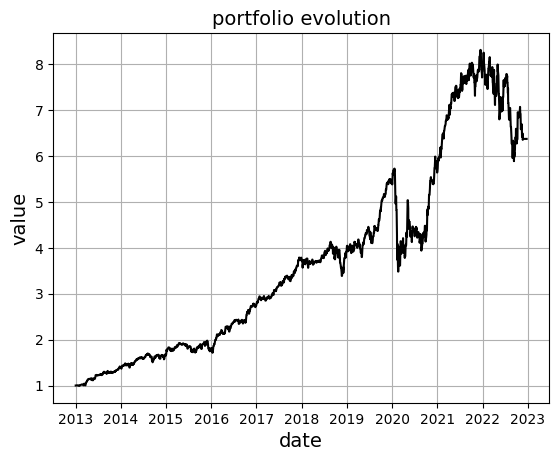

In [8]:
# also this way is fine, 
days = df_results['dates'].tolist()
portfolio = df_results['portfolio'].tolist()
  
plt.plot(days, portfolio, color='black')
plt.title('portfolio evolution', fontsize=14)
plt.xlabel('date', fontsize=14)
plt.ylabel('value', fontsize=14)
plt.grid(True)
plt.show()